In [1]:
%matplotlib inline
import matplotlib
print('matplotlib version:', matplotlib.__version__)
import matplotlib.pyplot as plt

import numpy as np
print('numpy version', np.__version__)
from numpy import median

import pandas as pd
print('pandas version:', pd.__version__)
from pandas import ExcelWriter
from pandas import ExcelFile

import seaborn as sns
print('seaborn version:', sns.__version__)
cmap = sns.cm.rocket_r
sns.set_style("white")

import scipy as sci
import scipy.sparse
print('scipy version:', sci.__version__)
from scipy import spatial
from scipy.stats import(kstest, poisson)

from adjustText import adjust_text
import gseapy as gp
print('gseapy version:', gp.__version__)

import mygene
mg = mygene.MyGeneInfo()
print('mygene version:', mygene.__version__)


matplotlib version: 3.5.1
numpy version 1.21.6
pandas version: 1.4.1
seaborn version: 0.11.2
scipy version: 1.8.0
gseapy version: 0.10.8
mygene version: 3.2.2


In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 80
plt.rc('font',family='Times New Roman') 


In [4]:
from matplotlib.colors import LinearSegmentedColormap
age_color=['#008c5f','#3b9868','#b0df83','#ed7c6a','#e54746','#177cb0','#a3dfdf']
myColors = ((0.8, 0.0, 0.0, 1.0), (0.0, 0.8, 0.0, 1.0), (0.0, 0.0, 0.8, 1.0))
#cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", colors)
colors=['#F7828A',"#F9C7C6","#FDFAF3","#D4E3D0","#9CCCA4",]
c = LinearSegmentedColormap.from_list('Custom', colors, len(colors))
colors.reverse()
c_r=LinearSegmentedColormap.from_list('Custom', colors, len(colors))

colors1=['#FC8D59','#91CF60']
c1 = LinearSegmentedColormap.from_list('Custom', colors1, len(colors1))

In [5]:
pair_mouse=pd.read_csv('data/pair_GRCm39.tsv',sep='\t')
pair_mouse.set_index(pair_mouse.columns[0],inplace=True)
pair_mouse=pair_mouse.dropna()
pair_mouse['symbol_L']=[i.upper() for i in pair_mouse['symbol']]
pair_mouse.head()

pair_human=pd.read_csv('data/pair_GRCh38.tsv',sep='\t')
pair_human.set_index(pair_human.columns[0],inplace=True)
pair_human=pair_human.dropna()

# HUVEC

In [6]:
data1=pd.read_csv('data/EC_result.csv')
data1=data1.set_index(data1.columns[0])

ret_index=list(set(pair_human.index.tolist()) & set(data1.index.tolist()))
data1=data1.loc[ret_index]
data1['Symbol']=pair_human.loc[ret_index]

data1['sig'] = 'normal'
data1.loc[(data1.log2FoldChange> 5 )&(data1.padj < 0.05),'sig'] = 'up'
data1.loc[(data1.log2FoldChange< -5)&(data1.padj < 0.05),'sig'] = 'down'
data1['log(padj)'] = -np.log10(data1['padj'])

data2=data1.copy()
data2.loc[data2['log(padj)']>10,'log(padj)']=10
data2.head()

data1.head()

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,Symbol,sig,log(padj)
Unnamed: 0,,,,,,,,,
ENSG00000231365,365.312544,0.262888,0.117724,2.233097,0.025543,0.051970,WARS2-AS1,normal,1.284247
ENSG00000104497,231.483354,0.536399,0.149699,3.583178,0.000339,0.000935,SNX16,normal,3.029407
ENSG00000228118,0.000000,NaN,NaN,NaN,NaN,NaN,MYL6P5,normal,NaN
ENSG00000141858,710.541103,-0.441792,0.096888,-4.559806,0.000005,0.000017,SAMD1,normal,4.767867
ENSG00000253755,0.000000,NaN,NaN,NaN,NaN,NaN,IGHGP,normal,NaN


In [7]:
len(data1.loc[data1['sig']!='normal'])

246

In [13]:
from net_string import *
rnk_gene=data1[data1['sig']!='normal'].index.tolist()
G1=generate_G(rnk_gene,9606)

In [14]:
rt1=string_map(data2[data2['sig']=='up'].index.tolist(),9606)
rt2=string_map(data2[data2['sig']=='down'].index.tolist(),9606)
rt11=rt1['preferredName'].tolist()
rt22=rt2['preferredName'].tolist()
rt111=[i.upper() for i in rt11]
rt222=[i.upper() for i in rt22]

p=dict(G1.nodes)
for i in p.keys():
  if i in rt11:
    p[i]=0
  elif i in rt22:
    p[i]=1
  else:
    p[i]=2

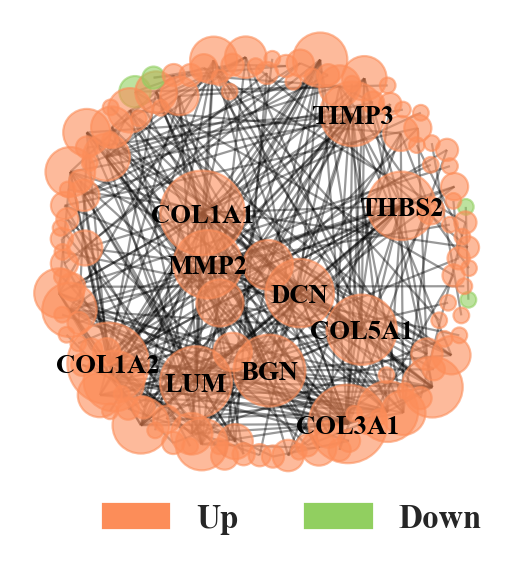

In [15]:
import matplotlib.patches as mpatches
import networkx as nx
np.random.seed(16)
pos = nx.spring_layout(G1, scale=10, k=(len(rnk_gene)//10)/np.sqrt(G1.order()))
d = dict(G1.degree)

plt.figure(figsize=(4, 4))
plt.style.use('seaborn-white')
plt.rc('font', family="Times New Roman")  # 再rc中整体修改plt的风格
nx.draw_networkx_edges(G1, pos, nodelist=[10], alpha=0.4)
degree_dict = dict(G1.degree(G1.nodes()))
#sorted(degree_dict.items(),key=lambda x: x[1],reverse=True)
nx.draw_networkx_nodes(
    G1,
    pos,
    nodelist=list(p.keys()),
    node_size=[degree_dict[v]*50 for v in G1],
    node_color=list(p.values()),
    cmap=c1,
    alpha=0.6,
    linewidths=1,
)

hub_gene=[i[0] for i in sorted(degree_dict.items(),key=lambda x: x[1],reverse=True)[:10]]
pos1=dict()
for i in pos.keys():
  pos1[i]=np.array([-1000,-1000])
for i in hub_gene:
  pos1[i]=pos[i]

nx.draw_networkx_labels(
    G1,pos1,verticalalignment='center_baseline',font_size=12,font_family='Times New Roman',
    font_weight='bold',
)
labels = ['Up', 'Down']  #legend标签列表，上面的color即是颜色列表
#用label和color列表生成mpatches.Patch对象，它将作为句柄来生成legend
color = ['#FC8D59','#91CF60']
patches = [ mpatches.Patch(color=color[i], label="{:s}".format(labels[i]) ) for i in range(len(color)) ] 

#plt.xlim(-0.05, 1.05)
#plt.ylim(-0.05, 1.05)
plt.axis("off")
plt.legend(handles=patches,bbox_to_anchor=(1, 0.05), ncol=3,fontsize=15)
leg = plt.gca().get_legend() #或leg=ax.get_legend()
ltext = leg.get_texts()
plt.setp(ltext, fontsize=15,fontweight='bold')
plt.savefig("result/HUVEC_network.png",dpi=300,bbox_inches = 'tight')

In [16]:
data1['sig'] = 'normal'
data1.loc[(data1.log2FoldChange> 2 )&(data1.padj < 0.05),'sig'] = 'up'
data1.loc[(data1.log2FoldChange< -2)&(data1.padj < 0.05),'sig'] = 'down'
data1['log(padj)'] = -np.log10(data1['padj'])

data2=data1.copy()
data2.loc[data2['log(padj)']>10,'log(padj)']=10
data2.head()

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,Symbol,sig,log(padj)
Unnamed: 0,,,,,,,,,
ENSG00000231365,365.312544,0.262888,0.117724,2.233097,0.025543,0.051970,WARS2-AS1,normal,1.284247
ENSG00000104497,231.483354,0.536399,0.149699,3.583178,0.000339,0.000935,SNX16,normal,3.029407
ENSG00000228118,0.000000,NaN,NaN,NaN,NaN,NaN,MYL6P5,normal,NaN
ENSG00000141858,710.541103,-0.441792,0.096888,-4.559806,0.000005,0.000017,SAMD1,normal,4.767867
ENSG00000253755,0.000000,NaN,NaN,NaN,NaN,NaN,IGHGP,normal,NaN


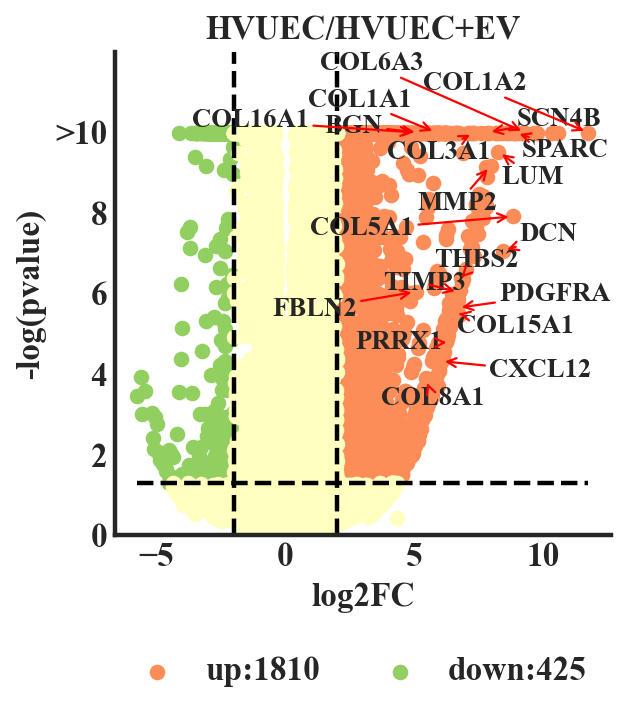

In [17]:
font1={
    'font':'Times New Roman',
    'weight':'bold',
    'size':15,
}
pp=plt.figure(figsize=(4,4))
ax=pp.add_subplot(1,1,1)
plt.scatter(x=data2[data2['sig']=='up']['log2FoldChange'],y=data2[data1['sig']=='up']['log(padj)'],color='#FC8D59',label='up')
plt.scatter(x=data2[data2['sig']=='down']['log2FoldChange'],y=data2[data1['sig']=='down']['log(padj)'],color='#91CF60',label='down')
plt.scatter(x=data2[data2['sig']=='normal']['log2FoldChange'],y=data2[data1['sig']=='normal']['log(padj)'],color='#FFFFBF',label='normal')

plt.yticks([0,2,4,6,8,10,12],['0','2','4','6','8','>10',''],fontsize=15,fontweight='bold')
plt.xticks(fontsize=15,fontweight='bold')
plt.ylim(0,12)
#plt.xlim(-10,10)
#plt.legend(loc='best',fontsize=15)
hub_gene=[i[0] for i in sorted(degree_dict.items(),key=lambda x: x[1],reverse=True)[:40]]
#hub_gene=['Atp5b','Atp5o','Atp5j','Hsp90aa1','Hspe1','Eif4a1','Eef1b2','Eif5a','Rplp0','Rpsa','Rps3a1','Rps14','Rpl15','Rpl13','Rpl22']
test=hub_gene
texts=[plt.text(data2[data2['Symbol']==i]['log2FoldChange'].values[0], data2[data2['Symbol']==i]['log(padj)'].values[0],
        i
        ,fontdict={'size':12,'weight':'bold'}) for i in test[:20]]

adjust_text(texts,only_move={'text': 'xy'},arrowprops=dict(arrowstyle='->', color='red'),)


plt.legend(['up:{0}'.format(len(data2[data2['sig']=='up'])),
      'down:{0}'.format(len(data2[data2['sig']=='down']))],bbox_to_anchor=(1, -0.2), ncol=2,fontsize=12)
leg = plt.gca().get_legend() #或leg=ax.get_legend()
ltext = leg.get_texts()
plt.setp(ltext, fontsize=15,fontweight='bold')

ax.set_ylabel('-log(pvalue)',font1)                                    
ax.set_xlabel('log2FC',font1)
ax.plot([data1['log2FoldChange'].min(),data1['log2FoldChange'].max()],[-np.log10(0.05),-np.log10(0.05)],linewidth=2, linestyle="--",color='black')
ax.plot([2,2],[data1['log(padj)'].min(),300],linewidth=2, linestyle="--",color='black')
ax.plot([-2,-2],[data1['log(padj)'].min(),300],linewidth=2, linestyle="--",color='black')
plt.title('HVUEC/HVUEC+EV',fontsize=15,fontweight='bold')

#绘制图像标题
ax=plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_linewidth(2);###设置底部坐标轴的粗细
ax.spines['left'].set_linewidth(2);####设置左边坐标轴的粗细
ax.spines['right'].set_linewidth(2);###设置右边坐标轴的粗细
ax.spines['top'].set_linewidth(2);####设置上部坐标轴的粗细

plt.savefig("result/HUVEC_volcano.png",dpi=300,bbox_inches = 'tight')
#plt.savefig("HVUEC_volcano.png",dpi=300,bbox_inches = 'tight')

In [18]:
data=pd.read_csv('data/EC_counts.csv')
data=data.set_index(data.columns[0])
data.head()

,EC1,EC1yuan,EC2,EC2yuan,EC3,EC3yuan
Geneid,,,,,,
ENSG00000223972,0,0,0,0,0,0
ENSG00000227232,118,154,161,116,132,120
ENSG00000278267,7,9,8,9,8,6
ENSG00000243485,0,0,0,0,0,0
ENSG00000284332,0,0,0,0,0,0


In [19]:
EC_heatmap_data=data.loc[rnk_gene]
EC_heatmap_data.index=data1.loc[rnk_gene]['Symbol'].tolist()
EC_heatmap_data.head()

,EC1,EC1yuan,EC2,EC2yuan,EC3,EC3yuan
SCTR-AS1,143,0,98,2,142,0
SAA4,37,0,29,0,49,0
HEPH,14,0,10,0,7,0
CACNG4,11,0,14,0,11,0
SMIM10L2A,283,10,290,2,271,6


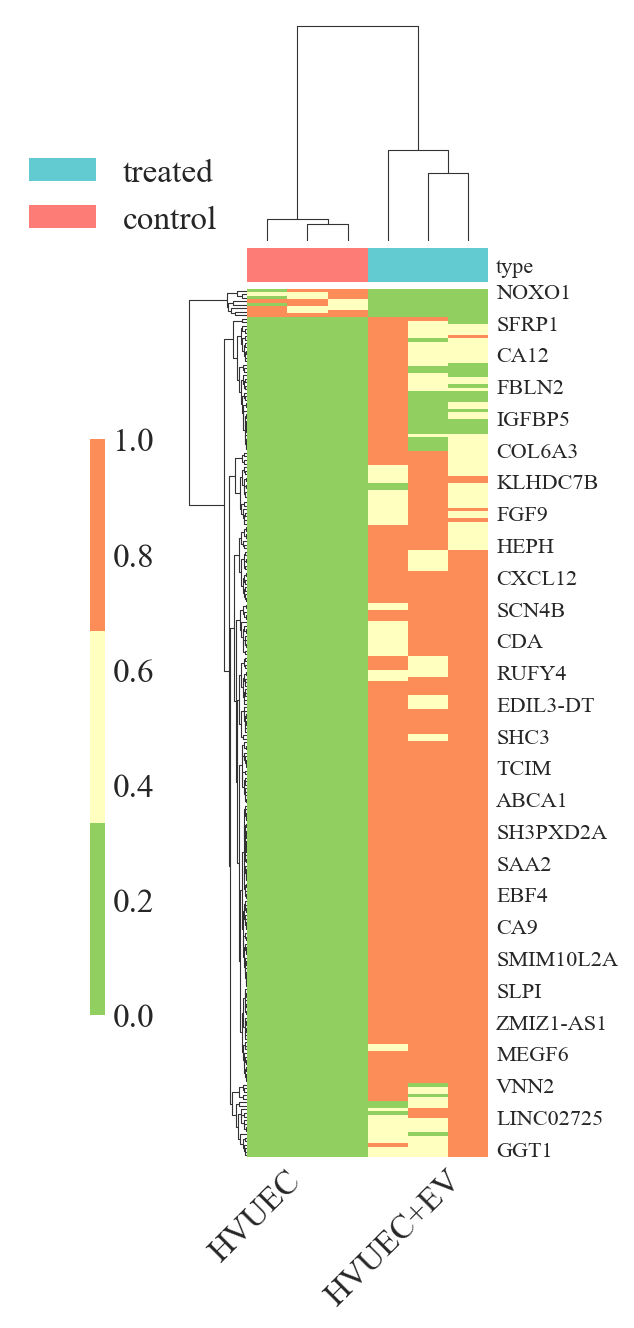

In [21]:
import palettable
meta=pd.read_csv('data/EC_meta.csv')
meta=meta.set_index(meta.columns[0])
col_c={
    'control':'#FD7C76',
    'treated':'#62CAD1'
}

a=sns.clustermap(EC_heatmap_data, 
               cmap=palettable.colorbrewer.diverging.RdYlGn_3_r.mpl_colors, 
               standard_scale = 0,figsize=(3,8),
              col_colors=meta['type'].map(col_c),
)
a.ax_heatmap.yaxis.set_tick_params(labelsize=10)
a.ax_heatmap.xaxis.set_tick_params(labelsize=15)
a.ax_heatmap.xaxis.set_ticklabels(['','HVUEC','','','','HVUEC+EV'])
labels=a.ax_heatmap.xaxis.get_ticklabels()
#a.ax_heatmap.xaxis.set_text(['','RAW','','','RAW+EV',''])
plt.setp(labels, rotation=45, horizontalalignment='right',)
for label in meta['type'].unique():
    a.ax_col_dendrogram.bar(0, 0, color=col_c[label],
                            label=label, linewidth=0)
a.ax_col_dendrogram.legend(loc="best", ncol=1,bbox_to_anchor=(-0.5, 0., 0.5, 0.5),fontsize=15)
a.cax.set_position([-.15, .2, .03, .45])
plt.setp(a.cax.yaxis.get_majorticklabels(), fontsize=15)
plt.savefig("result/HUVEC_heatmap.png",dpi=300,bbox_inches = 'tight')
#plt.savefig("HVUEC_heatmap.png",dpi=300,bbox_inches = 'tight')

In [22]:
enr = gp.enrichr(gene_list=EC_heatmap_data.index.tolist(),
    gene_sets='KEGG_2019_Human',
    organism='Human', # don't forget to set organism to the one you desired! e.g. Yeast
    description='description',
    outdir='data/enrichment_KEGG_EC',
     # no_plot=True,
    cutoff=0.5 # test dataset, use lower value from range(0,1)
)
#subp=dotplot(enr.res2d, title=description,cmap='seismic')
#print(subp)
enr.res2d.head()

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,KEGG_2019_Human,Protein digestion and absorption,10/90,1.594977e-07,0.000026,0,0,10.420551,163.094507,DPP4;COL1A1;COL15A1;COL3A1;COL1A2;COL5A1;FXYD2...
1,KEGG_2019_Human,ECM-receptor interaction,6/82,5.228207e-04,0.042871,0,0,6.473026,48.911947,COL1A1;RELN;COL1A2;LAMA4;COL6A3;THBS2
2,KEGG_2019_Human,Focal adhesion,9/199,8.263222e-04,0.045172,0,0,3.910193,27.756607,COL1A1;PDGFRA;SHC2;COL1A2;RELN;SHC3;LAMA4;COL6...
3,KEGG_2019_Human,Calcium signaling pathway,8/188,2.335249e-03,0.095745,0,0,3.655275,22.149642,CAMK2B;PDGFRA;CACNA1I;AVPR1B;PDE1A;BDKRB2;BDKR...
4,KEGG_2019_Human,Proteoglycans in cancer,8/201,3.516992e-03,0.115357,0,0,3.406801,19.248934,CAMK2B;WNT6;WNT11;LUM;MMP2;TWIST2;TIMP3;DCN


In [23]:
kegg_result_ec=enr.res2d[enr.res2d['P-value']<0.05]
kegg_result_ec['logp']=-np.log(kegg_result_ec['Adjusted P-value'])
kegg_result_ec['logc']=np.log(kegg_result_ec['Combined Score'])
kegg_result_ec['num']=[int(i.split('/')[0]) for i in kegg_result_ec['Overlap']]

In [24]:
def plot_text_set(text):
  if len(text)>10:
    t=text.split(' ')
    n=0
    res=''
    for i in t:
      if n==0:
        res=i 
      else:
        res=res+'\n'+i
      n+=1
    return res
  else:
    return text

In [25]:
kegg_result_ec.to_excel('result/HUVEC_KEGG_pathway(normal).xlsx')

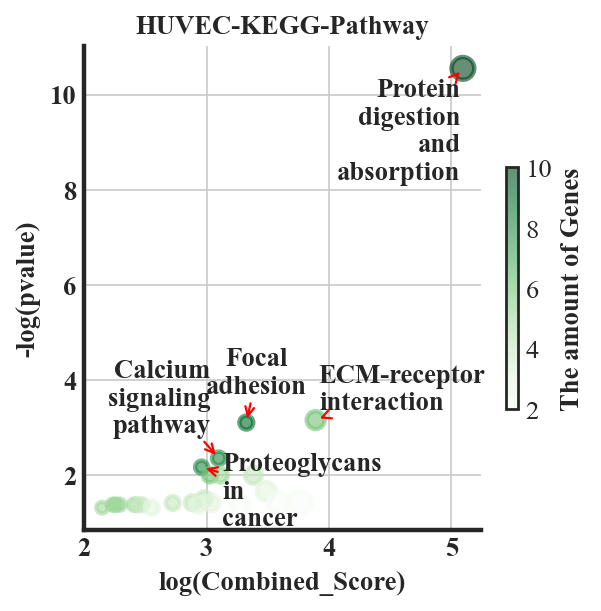

In [26]:
pp=plt.figure(figsize=(4,4))
#用ax控制图片
ax=pp.add_subplot(1,1,1)

plt.scatter(kegg_result_ec['logc'],kegg_result_ec['logp'],
      s=kegg_result_ec['Odds Ratio']*10,c=kegg_result_ec['num'],cmap='Greens',alpha=0.6,linewidth=2,)

test=kegg_result_ec['Term'].values
texts=[plt.text(kegg_result_ec[kegg_result_ec['Term']==i]['logc'].values[0], kegg_result_ec[kegg_result_ec['Term']==i]['logp'].values[0],
        plot_text_set(i)
        ,fontdict={'size':12,'weight':'bold'}) for i in test[:5]]

adjust_text(texts,only_move={'text': 'xy'},arrowprops=dict(arrowstyle='->', color='red'),)


#plt.annotate(me_result.index[0], xy=(me_result['Impact'][0],me_result['-log10(p)'][0]), xytext=(0.2,2),
#bbox=dict(boxstyle='round,pad=0.3', fc='white', alpha=0.5),arrowprops=dict(arrowstyle='-',color='black'),size=15)

#plt.annotate(me_result.index[1], xy=(me_result['Impact'][1],me_result['-log10(p)'][1]), xytext=(0.2,1.5),
#bbox=dict(boxstyle='round,pad=0.3', fc='white', alpha=0.5),arrowprops=dict(arrowstyle='-',color='black'),size=15)

#plt.annotate(me_result.index[2], xy=(me_result['Impact'][2],me_result['-log10(p)'][2]), xytext=(0.2,1),
#bbox=dict(boxstyle='round,pad=0.3', fc='white', alpha=0.5),arrowprops=dict(arrowstyle='-',color='black'),size=15)

#设置横纵坐标轴字体
plt.yticks(fontsize=12,fontweight='bold')
plt.xticks(fontsize=12,fontweight='bold')
#设置图注
#plt.legend(loc='center right', bbox_to_anchor=(0, -.5), ncol=3,fontsize=12)
#设置横纵标题
plt.ylabel('-log(pvalue)',fontsize=12,fontweight='bold')                   
plt.xlabel('log(Combined_Score)',fontsize=12,fontweight='bold')
plt.title('HUVEC-KEGG-Pathway',fontsize=12,fontweight='bold')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_linewidth(2);###设置底部坐标轴的粗细
ax.spines['left'].set_linewidth(2);####设置左边坐标轴的粗细
ax.spines['right'].set_linewidth(2);###设置右边坐标轴的粗细
ax.spines['top'].set_linewidth(2);####设置上部坐标轴的粗细

cb=plt.colorbar(label="The amount of Genes",shrink=0.5) 
cb.ax.tick_params(labelsize=12)
#plt.xticks(fontsize=12)
plt.grid(None)
cb.set_label('The amount of Genes',fontdict={'size':12,'weight':'bold'})
#plt.savefig("kegg_ad.png",dpi=300,bbox_inches = 'tight')
plt.savefig("result/HUVEC_kegg.png",dpi=300,bbox_inches = 'tight')

## gsea

In [27]:
gseada=data1.loc[data1['sig']!='normal']
gseada=data1
gseada['fcsign']=-np.sign(gseada['log2FoldChange'])
gseada['logp']=-np.log10(gseada['pvalue'])
gseada['metric']=gseada['logp']/gseada['fcsign']
gseada.head()

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,Symbol,sig,log(padj),fcsign,logp,metric
Unnamed: 0,,,,,,,,,,,,
ENSG00000231365,365.312544,0.262888,0.117724,2.233097,0.025543,0.051970,WARS2-AS1,normal,1.284247,-1.0,1.592736,-1.592736
ENSG00000104497,231.483354,0.536399,0.149699,3.583178,0.000339,0.000935,SNX16,normal,3.029407,-1.0,3.469239,-3.469239
ENSG00000228118,0.000000,NaN,NaN,NaN,NaN,NaN,MYL6P5,normal,NaN,NaN,NaN,NaN
ENSG00000141858,710.541103,-0.441792,0.096888,-4.559806,0.000005,0.000017,SAMD1,normal,4.767867,1.0,5.290723,5.290723
ENSG00000253755,0.000000,NaN,NaN,NaN,NaN,NaN,IGHGP,normal,NaN,NaN,NaN,NaN


In [28]:
gseada=gseada.sort_values(by=['metric'],ascending=False)
gseada.head()

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,Symbol,sig,log(padj),fcsign,logp,metric
Unnamed: 0,,,,,,,,,,,,
ENSG00000134057,3317.837530,-2.912717,0.069634,-41.828766,0.0,0.0,CCNB1,down,inf,1.0,inf,inf
ENSG00000108854,5313.715625,-2.310360,0.059113,-39.083582,0.0,0.0,SMURF2,down,inf,1.0,inf,inf
ENSG00000088325,6327.912975,-2.508552,0.062576,-40.088003,0.0,0.0,TPX2,down,inf,1.0,inf,inf
ENSG00000110092,11524.843066,-2.311731,0.055154,-41.914337,0.0,0.0,CCND1,down,inf,1.0,inf,inf
ENSG00000111206,3152.963351,-2.946250,0.070661,-41.695354,0.0,0.0,FOXM1,down,inf,1.0,inf,inf


In [29]:
rnk=pd.DataFrame()
rnk['gene_name']=gseada.index
rnk['rnk']=gseada['metric'].values
k=1
total=0
for i in range(len(rnk)):
    if rnk.loc[i,'rnk']==np.inf: 
        total+=1

for i in range(len(rnk)):
    if rnk.loc[i,'rnk']==np.inf: 
        rnk.loc[i,'rnk']=307+(total-k)
        k+=1
    elif rnk.loc[i,'rnk']==-np.inf: 
        rnk.loc[i,'rnk']=-(300+k)
        k+=1
#rnk=rnk.replace(np.inf,300)
#rnk=rnk.replace(-np.inf,-300)
rnk['gene_name']=gseada['Symbol'].tolist()
rnk=rnk.dropna()
rnk.head()

,gene_name,rnk
0,CCNB1,325.0
1,SMURF2,324.0
2,TPX2,323.0
3,CCND1,322.0
4,FOXM1,321.0


In [30]:
rnk.shape

(25790, 2)

In [31]:
pre_res = gp.prerank(rnk=rnk, gene_sets='KEGG_2019_Human',
                     processes=16,
                     permutation_num=100, # reduce number to speed up testing
                     outdir='result/EC_gsea/prerank_report_kegg', format='png', seed=6)

2022-06-22 19:36:43,932 Input gene rankings contains duplicated IDs, Only use the duplicated ID with highest value!


In [32]:
pre_res.res2d.head()

,es,nes,pval,fdr,geneset_size,matched_size,genes,ledge_genes
Term,,,,,,,,
Cell cycle,0.867944,1.793117,0.0,0.0,124,123,CCNB1;CCND1;PLK1;MCM4;CDC6;CDC20;MCM3;PCNA;MCM...,CCNB1;CCND1;PLK1;MCM4;CDC6;CDC20;MCM3;PCNA;MCM...
Neuroactive ligand-receptor interaction,-0.693541,-1.757631,0.0,0.0,338,220,CHRNB1;NMU;CHRNA5;GAL;ADORA2B;ADRB2;TSPO;P2RX5...,NR3C1;NPY1R;LPAR1;OPRL1;LEPR;HTR6;BDKRB2;ADRA2...
Nicotine addiction,-0.954443,-1.813116,0.0,0.0,40,25,GRIN2C;CACNA1B;GABRG3;GABRP;GABRR3;GRIN2B;SLC3...,GRIN2D;SLC17A7;GRIN3B
RNA transport,0.790156,1.717022,0.0,0.0,165,155,ALYREF;TACC3;EIF4G1;RANGAP1;NUP188;RAN;NUP50;N...,ALYREF;TACC3;EIF4G1;RANGAP1;NUP188;RAN;NUP50;N...
Ribosome biogenesis in eukaryotes,0.875752,1.774011,0.0,0.0,101,81,NOP56;DKC1;NOL6;GNL3L;TCOF1;RAN;GNL3;NOP58;POP...,NOP56;DKC1;NOL6;GNL3L;TCOF1;RAN;GNL3;NOP58;POP...


In [33]:
# extract geneset terms in res2d
terms = pre_res.res2d.index
terms

Index(['Cell cycle', 'Neuroactive ligand-receptor interaction',
       'Nicotine addiction', 'RNA transport',
       'Ribosome biogenesis in eukaryotes', 'Spliceosome', 'DNA replication',
       'Proteasome', 'Oocyte meiosis', 'Epstein-Barr virus infection',
       ...
       'Glycosphingolipid biosynthesis', 'Autoimmune thyroid disease',
       'Renin-angiotensin system', 'Vascular smooth muscle contraction',
       'Retrograde endocannabinoid signaling', 'mTOR signaling pathway',
       'Morphine addiction', 'alpha-Linolenic acid metabolism',
       'Long-term potentiation', 'Mitophagy'],
      dtype='object', name='Term', length=289)

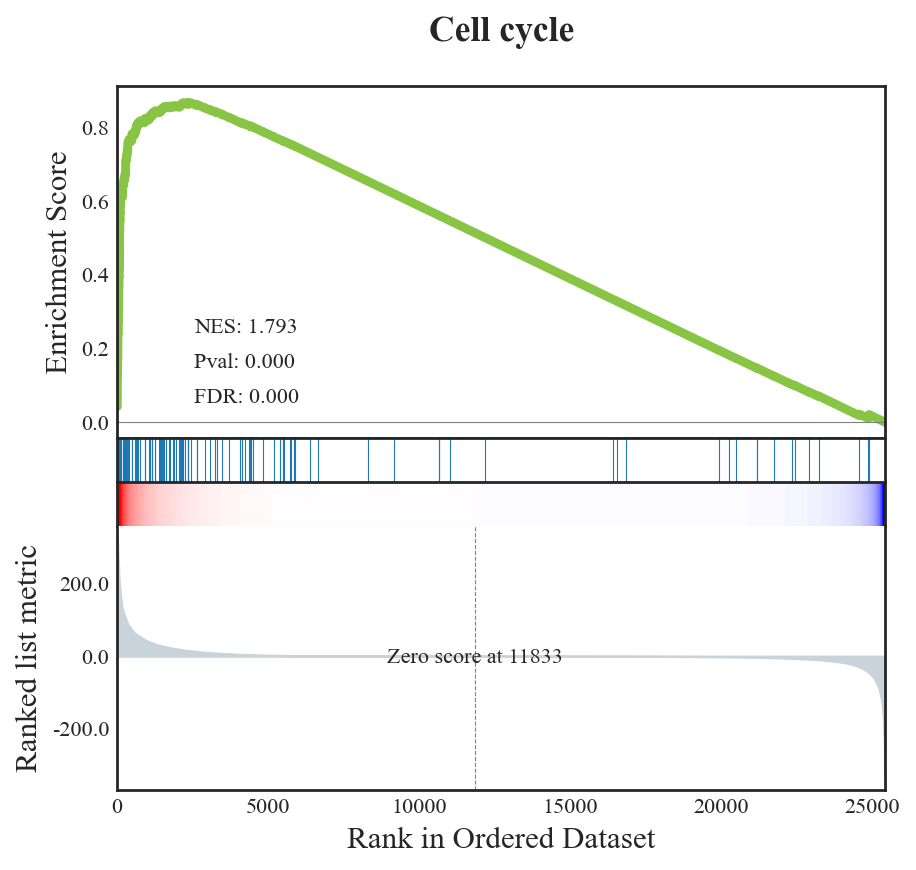

In [34]:
from gseapy.plot import gseaplot

# to save your figure, make sure that ofname is not None
gseaplot(rank_metric=pre_res.ranking, term=terms[0], **pre_res.results[terms[0]])

# NHDF

In [35]:
data1=pd.read_csv('data/NEGF_result.csv')
data1=data1.set_index(data1.columns[0])

ret_index=list(set(pair_human.index.tolist()) & set(data1.index.tolist()))
data1=data1.loc[ret_index]
data1['Symbol']=pair_human.loc[ret_index]

data1['sig'] = 'normal'
data1.loc[(data1.log2FoldChange> 4 )&(data1.padj < 0.05),'sig'] = 'up'
data1.loc[(data1.log2FoldChange< -4)&(data1.padj < 0.05),'sig'] = 'down'
data1['log(padj)'] = -np.log10(data1['padj'])

data2=data1.copy()
data2.loc[data2['log(padj)']>10,'log(padj)']=10
data2.head()

data1.head()

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,Symbol,sig,log(padj)
Unnamed: 0,,,,,,,,,
ENSG00000231365,226.147044,-0.196677,0.178893,-1.099412,0.271588,0.469330,WARS2-AS1,normal,0.328522
ENSG00000104497,152.209521,0.670644,0.222702,3.011402,0.002600,0.012119,SNX16,normal,1.916522
ENSG00000228118,0.619634,-2.669214,3.117102,-0.856313,0.391825,NaN,MYL6P5,normal,NaN
ENSG00000141858,614.923454,-0.368003,0.147564,-2.493858,0.012636,0.045209,SAMD1,normal,1.344775
ENSG00000253755,0.000000,NaN,NaN,NaN,NaN,NaN,IGHGP,normal,NaN


In [36]:
len(data1.loc[data1['sig']!='normal'])

200

In [38]:
from net_string import *
rnk_gene=data1[data1['sig']!='normal'].index.tolist()
G1=generate_G(rnk_gene,9606)

In [39]:
rt1=string_map(data2[data2['sig']=='up'].index.tolist(),9606)
rt2=string_map(data2[data2['sig']=='down'].index.tolist(),9606)
rt11=rt1['preferredName'].tolist()
rt22=rt2['preferredName'].tolist()
rt111=[i.upper() for i in rt11]
rt222=[i.upper() for i in rt22]

p=dict(G1.nodes)
for i in p.keys():
  if i in rt11:
    p[i]=0
  elif i in rt22:
    p[i]=1
  else:
    p[i]=2

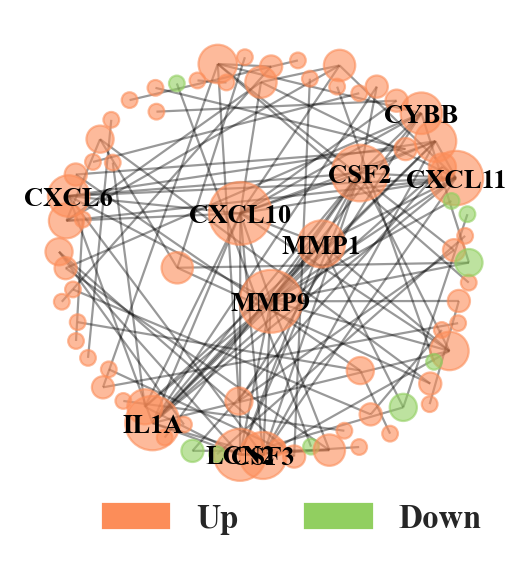

In [40]:
import matplotlib.patches as mpatches
import networkx as nx
np.random.seed(43)
pos = nx.spring_layout(G1, scale=10, k=(len(rnk_gene)//10)/np.sqrt(G1.order()))
d = dict(G1.degree)

plt.figure(figsize=(4, 4))
plt.style.use('seaborn-white')
plt.rc('font', family="Times New Roman")  # 再rc中整体修改plt的风格
nx.draw_networkx_edges(G1, pos, nodelist=[10], alpha=0.4)
degree_dict = dict(G1.degree(G1.nodes()))
#sorted(degree_dict.items(),key=lambda x: x[1],reverse=True)
nx.draw_networkx_nodes(
    G1,
    pos,
    nodelist=list(p.keys()),
    node_size=[degree_dict[v]*50 for v in G1],
    node_color=list(p.values()),
    cmap=c1,
    alpha=0.6,
    linewidths=1,
)

hub_gene=[i[0] for i in sorted(degree_dict.items(),key=lambda x: x[1],reverse=True)[:10]]
pos1=dict()
for i in pos.keys():
  pos1[i]=np.array([-1000,-1000])
for i in hub_gene:
  pos1[i]=pos[i]

nx.draw_networkx_labels(
    G1,pos1,verticalalignment='center_baseline',font_size=12,font_family='Times New Roman',
    font_weight='bold',
)
labels = ['Up', 'Down']  #legend标签列表，上面的color即是颜色列表
#用label和color列表生成mpatches.Patch对象，它将作为句柄来生成legend
color = ['#FC8D59','#91CF60']
patches = [ mpatches.Patch(color=color[i], label="{:s}".format(labels[i]) ) for i in range(len(color)) ] 

#plt.xlim(-0.05, 1.05)
#plt.ylim(-0.05, 1.05)
plt.axis("off")
plt.legend(handles=patches,bbox_to_anchor=(1, 0.05), ncol=3,fontsize=15)
leg = plt.gca().get_legend() #或leg=ax.get_legend()
ltext = leg.get_texts()
plt.setp(ltext, fontsize=15,fontweight='bold')
plt.savefig("result/NHDF_network.png",dpi=300,bbox_inches = 'tight')

In [41]:
data1['sig'] = 'normal'
data1.loc[(data1.log2FoldChange> 2 )&(data1.padj < 0.05),'sig'] = 'up'
data1.loc[(data1.log2FoldChange< -2)&(data1.padj < 0.05),'sig'] = 'down'
data1['log(padj)'] = -np.log10(data1['padj'])

data2=data1.copy()
data2.loc[data2['log(padj)']>10,'log(padj)']=10
data2.head()

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,Symbol,sig,log(padj)
Unnamed: 0,,,,,,,,,
ENSG00000231365,226.147044,-0.196677,0.178893,-1.099412,0.271588,0.469330,WARS2-AS1,normal,0.328522
ENSG00000104497,152.209521,0.670644,0.222702,3.011402,0.002600,0.012119,SNX16,normal,1.916522
ENSG00000228118,0.619634,-2.669214,3.117102,-0.856313,0.391825,NaN,MYL6P5,normal,NaN
ENSG00000141858,614.923454,-0.368003,0.147564,-2.493858,0.012636,0.045209,SAMD1,normal,1.344775
ENSG00000253755,0.000000,NaN,NaN,NaN,NaN,NaN,IGHGP,normal,NaN


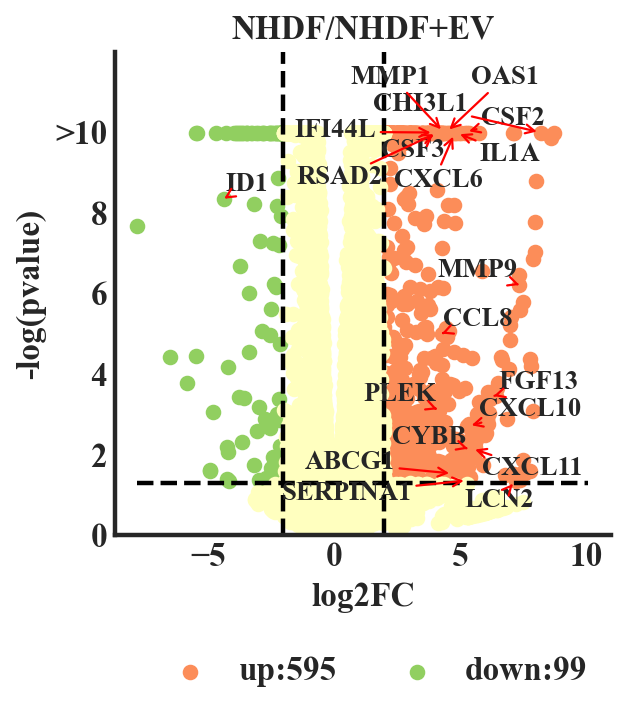

In [42]:
font1={
    'font':'Times New Roman',
    'weight':'bold',
    'size':15,
}
pp=plt.figure(figsize=(4,4))
ax=pp.add_subplot(1,1,1)
plt.scatter(x=data2[data2['sig']=='up']['log2FoldChange'],y=data2[data1['sig']=='up']['log(padj)'],color='#FC8D59',label='up')
plt.scatter(x=data2[data2['sig']=='down']['log2FoldChange'],y=data2[data1['sig']=='down']['log(padj)'],color='#91CF60',label='down')
plt.scatter(x=data2[data2['sig']=='normal']['log2FoldChange'],y=data2[data1['sig']=='normal']['log(padj)'],color='#FFFFBF',label='normal')

plt.yticks([0,2,4,6,8,10,12],['0','2','4','6','8','>10',''],fontsize=15,fontweight='bold')
plt.xticks(fontsize=15,fontweight='bold')
plt.ylim(0,12)
#plt.xlim(-10,10)
#plt.legend(loc='best',fontsize=15)
hub_gene=[i[0] for i in sorted(degree_dict.items(),key=lambda x: x[1],reverse=True)[:40]]
#hub_gene=['Atp5b','Atp5o','Atp5j','Hsp90aa1','Hspe1','Eif4a1','Eef1b2','Eif5a','Rplp0','Rpsa','Rps3a1','Rps14','Rpl15','Rpl13','Rpl22']
test=hub_gene
texts=[plt.text(data2[data2['Symbol']==i]['log2FoldChange'].values[0], data2[data2['Symbol']==i]['log(padj)'].values[0],
        i
        ,fontdict={'size':12,'weight':'bold'}) for i in test[:20]]

adjust_text(texts,only_move={'text': 'xy'},arrowprops=dict(arrowstyle='->', color='red'),)


plt.legend(['up:{0}'.format(len(data2[data2['sig']=='up'])),
      'down:{0}'.format(len(data2[data2['sig']=='down']))],bbox_to_anchor=(1, -0.2), ncol=2,fontsize=12)
leg = plt.gca().get_legend() #或leg=ax.get_legend()
ltext = leg.get_texts()
plt.setp(ltext, fontsize=15,fontweight='bold')

ax.set_ylabel('-log(pvalue)',font1)                                    
ax.set_xlabel('log2FC',font1)
ax.plot([data1['log2FoldChange'].min(),data1['log2FoldChange'].max()],[-np.log10(0.05),-np.log10(0.05)],linewidth=2, linestyle="--",color='black')
ax.plot([2,2],[data1['log(padj)'].min(),300],linewidth=2, linestyle="--",color='black')
ax.plot([-2,-2],[data1['log(padj)'].min(),300],linewidth=2, linestyle="--",color='black')
plt.title('NHDF/NHDF+EV',fontsize=15,fontweight='bold')

#绘制图像标题
ax=plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_linewidth(2);###设置底部坐标轴的粗细
ax.spines['left'].set_linewidth(2);####设置左边坐标轴的粗细
ax.spines['right'].set_linewidth(2);###设置右边坐标轴的粗细
ax.spines['top'].set_linewidth(2);####设置上部坐标轴的粗细

plt.savefig("result/NHDF_volcano.png",dpi=300,bbox_inches = 'tight')
#plt.savefig("HVUEC_volcano.png",dpi=300,bbox_inches = 'tight')

In [43]:
data=pd.read_csv('data/NEGF_counts.csv')
data=data.set_index(data.columns[0])
data.head()

,NEGF1,NEGF1yuan,NEGF2yuan,NEGF3,NEGF3yuan
Geneid,,,,,
ENSG00000223972,0,0,0,2,1
ENSG00000227232,82,63,80,79,63
ENSG00000278267,11,2,10,5,3
ENSG00000243485,0,0,1,0,0
ENSG00000284332,0,0,0,0,0


In [44]:
NHDF_heatmap_data=data.loc[rnk_gene]
NHDF_heatmap_data.index=data1.loc[rnk_gene]['Symbol'].tolist()
NHDF_heatmap_data.head()

,NEGF1,NEGF1yuan,NEGF2yuan,NEGF3,NEGF3yuan
RPSAP28,3,0,0,4,0
RPL26P28,2,0,0,3,0
C11orf96,128,9,5,85,7
ENTPD8,6,0,0,3,0
CYYR1,3,0,2,4,0


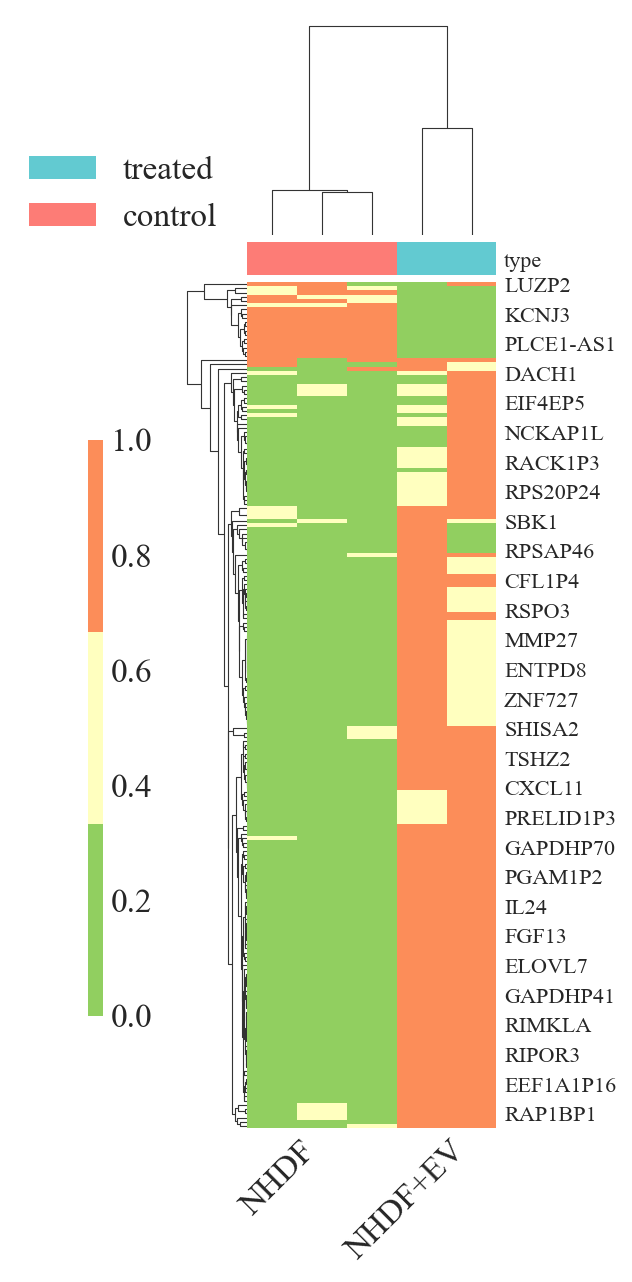

In [45]:
import palettable
meta=pd.read_csv('data/NEGF_meta.csv')
meta=meta.set_index(meta.columns[0])
col_c={
    'control':'#FD7C76',
    'treated':'#62CAD1'
}

a=sns.clustermap(NHDF_heatmap_data, 
               cmap=palettable.colorbrewer.diverging.RdYlGn_3_r.mpl_colors, 
               standard_scale = 0,figsize=(3,8),
              col_colors=meta['type'].map(col_c),
)
a.ax_heatmap.yaxis.set_tick_params(labelsize=10)
a.ax_heatmap.xaxis.set_tick_params(labelsize=15)
a.ax_heatmap.xaxis.set_ticklabels(['','NHDF','','','NHDF+EV'])
labels=a.ax_heatmap.xaxis.get_ticklabels()
#a.ax_heatmap.xaxis.set_text(['','RAW','','','RAW+EV',''])
plt.setp(labels, rotation=45, horizontalalignment='right',)
for label in meta['type'].unique():
    a.ax_col_dendrogram.bar(0, 0, color=col_c[label],
                            label=label, linewidth=0)
a.ax_col_dendrogram.legend(loc="best", ncol=1,bbox_to_anchor=(-0.5, 0., 0.5, 0.5),fontsize=15)
a.cax.set_position([-.15, .2, .03, .45])
plt.setp(a.cax.yaxis.get_majorticklabels(), fontsize=15)
plt.savefig("result/NHDF_heatmap.png",dpi=300,bbox_inches = 'tight')
#plt.savefig("HVUEC_heatmap.png",dpi=300,bbox_inches = 'tight')

In [46]:
enr = gp.enrichr(gene_list=NHDF_heatmap_data.index.tolist(),
    gene_sets='KEGG_2019_Human',
    organism='Human', # don't forget to set organism to the one you desired! e.g. Yeast
    description='description',
    outdir='result/enrichment_KEGG_NHDF',
     # no_plot=True,
    cutoff=0.5 # test dataset, use lower value from range(0,1)
)
#subp=dotplot(enr.res2d, title=description,cmap='seismic')
#print(subp)
enr.res2d.head()

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,KEGG_2019_Human,IL-17 signaling pathway,7/93,0.000041,0.005691,0,0,8.314134,83.939859,CXCL6;CXCL10;CSF3;CSF2;MMP1;LCN2;MMP9
1,KEGG_2019_Human,Cytokine-cytokine receptor interaction,10/294,0.000783,0.053998,0,0,3.616753,25.870334,IL1A;CXCL10;CXCL6;CXCL11;CSF3;CSF2;CCL8;IL34;I...
2,KEGG_2019_Human,Primary bile acid biosynthesis,2/17,0.012260,0.303507,0,0,13.323232,58.641399,CH25H;CYP7B1
3,KEGG_2019_Human,Chemokine signaling pathway,6/190,0.012300,0.303507,0,0,3.297176,14.501472,VAV3;CXCL10;CXCL6;HCK;CXCL11;CCL8
4,KEGG_2019_Human,Signaling pathways regulating pluripotency of ...,5/139,0.013015,0.303507,0,0,3.763108,16.338063,WNT10A;ID1;ID3;WNT7A;INHBE


In [47]:
kegg_result_nhdf=enr.res2d[enr.res2d['P-value']<0.05]
kegg_result_nhdf['logp']=-np.log(kegg_result_nhdf['Adjusted P-value'])
kegg_result_nhdf['logc']=np.log(kegg_result_nhdf['Combined Score'])
kegg_result_nhdf['num']=[int(i.split('/')[0]) for i in kegg_result_nhdf['Overlap']]

In [48]:
def plot_text_set(text):
  if len(text)>10:
    t=text.split(' ')
    n=0
    res=''
    for i in t:
      if n==0:
        res=i 
      else:
        res=res+'\n'+i
      n+=1
    return res
  else:
    return text

In [49]:
kegg_result_nhdf.to_excel('result/NHDF_KEGG_pathway(normal).xlsx')

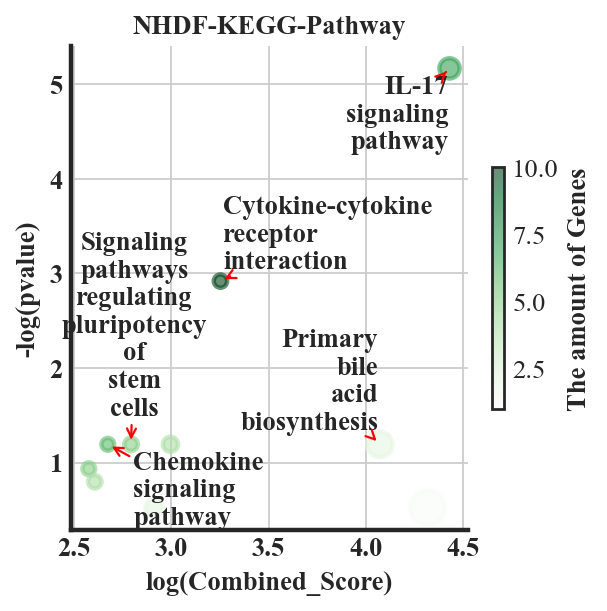

In [50]:
pp=plt.figure(figsize=(4,4))
#用ax控制图片
ax=pp.add_subplot(1,1,1)

plt.scatter(kegg_result_nhdf['logc'],kegg_result_nhdf['logp'],
      s=kegg_result_nhdf['Odds Ratio']*10,c=kegg_result_nhdf['num'],cmap='Greens',alpha=0.6,linewidth=2,)

test=kegg_result_nhdf['Term'].values
texts=[plt.text(kegg_result_nhdf[kegg_result_nhdf['Term']==i]['logc'].values[0], kegg_result_nhdf[kegg_result_nhdf['Term']==i]['logp'].values[0],
        plot_text_set(i)
        ,fontdict={'size':12,'weight':'bold'}) for i in test[:5]]

adjust_text(texts,only_move={'text': 'xy'},arrowprops=dict(arrowstyle='->', color='red'),)


#plt.annotate(me_result.index[0], xy=(me_result['Impact'][0],me_result['-log10(p)'][0]), xytext=(0.2,2),
#bbox=dict(boxstyle='round,pad=0.3', fc='white', alpha=0.5),arrowprops=dict(arrowstyle='-',color='black'),size=15)

#plt.annotate(me_result.index[1], xy=(me_result['Impact'][1],me_result['-log10(p)'][1]), xytext=(0.2,1.5),
#bbox=dict(boxstyle='round,pad=0.3', fc='white', alpha=0.5),arrowprops=dict(arrowstyle='-',color='black'),size=15)

#plt.annotate(me_result.index[2], xy=(me_result['Impact'][2],me_result['-log10(p)'][2]), xytext=(0.2,1),
#bbox=dict(boxstyle='round,pad=0.3', fc='white', alpha=0.5),arrowprops=dict(arrowstyle='-',color='black'),size=15)

#设置横纵坐标轴字体
plt.yticks(fontsize=12,fontweight='bold')
plt.xticks(fontsize=12,fontweight='bold')
#设置图注
#plt.legend(loc='center right', bbox_to_anchor=(0, -.5), ncol=3,fontsize=12)
#设置横纵标题
plt.ylabel('-log(pvalue)',fontsize=12,fontweight='bold')                   
plt.xlabel('log(Combined_Score)',fontsize=12,fontweight='bold')
plt.title('NHDF-KEGG-Pathway',fontsize=12,fontweight='bold')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_linewidth(2);###设置底部坐标轴的粗细
ax.spines['left'].set_linewidth(2);####设置左边坐标轴的粗细
ax.spines['right'].set_linewidth(2);###设置右边坐标轴的粗细
ax.spines['top'].set_linewidth(2);####设置上部坐标轴的粗细

cb=plt.colorbar(label="The amount of Genes",shrink=0.5) 
cb.ax.tick_params(labelsize=12)
#plt.xticks(fontsize=12)
plt.grid(None)
cb.set_label('The amount of Genes',fontdict={'size':12,'weight':'bold'})
#plt.savefig("kegg_ad.png",dpi=300,bbox_inches = 'tight')
plt.savefig("result/NHDF_kegg.png",dpi=300,bbox_inches = 'tight')

## gsea

In [51]:
gseada=data1.loc[data1['sig']!='normal']
gseada=data1
gseada['fcsign']=-np.sign(gseada['log2FoldChange'])
gseada['logp']=-np.log10(gseada['pvalue'])
gseada['metric']=gseada['logp']/gseada['fcsign']
gseada.head()

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,Symbol,sig,log(padj),fcsign,logp,metric
Unnamed: 0,,,,,,,,,,,,
ENSG00000231365,226.147044,-0.196677,0.178893,-1.099412,0.271588,0.469330,WARS2-AS1,normal,0.328522,1.0,0.566089,0.566089
ENSG00000104497,152.209521,0.670644,0.222702,3.011402,0.002600,0.012119,SNX16,normal,1.916522,-1.0,2.584953,-2.584953
ENSG00000228118,0.619634,-2.669214,3.117102,-0.856313,0.391825,NaN,MYL6P5,normal,NaN,1.0,0.406908,0.406908
ENSG00000141858,614.923454,-0.368003,0.147564,-2.493858,0.012636,0.045209,SAMD1,normal,1.344775,1.0,1.898380,1.898380
ENSG00000253755,0.000000,NaN,NaN,NaN,NaN,NaN,IGHGP,normal,NaN,NaN,NaN,NaN


In [52]:
gseada=gseada.sort_values(by=['metric'],ascending=False)
gseada.head()

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,Symbol,sig,log(padj),fcsign,logp,metric
Unnamed: 0,,,,,,,,,,,,
ENSG00000168874,1846.323546,-3.464845,0.126884,-27.307195,3.484154e-164,5.834797e-161,ATOH8,down,160.233974,1.0,163.457903,163.457903
ENSG00000180914,3473.963625,-3.071880,0.115227,-26.659276,1.397164e-156,2.159801e-153,OXTR,down,152.665586,1.0,155.854753,155.854753
ENSG00000214517,2682.161996,-2.291377,0.096438,-23.760042,8.651868e-125,7.903088e-122,PPME1,down,121.102203,1.0,124.062890,124.062890
ENSG00000198431,12038.923083,-2.176989,0.094906,-22.938477,1.920346e-116,1.378260e-113,TXNRD1,down,112.860669,1.0,115.716620,115.716620
ENSG00000181019,6321.852680,-1.943537,0.088316,-22.006670,2.485921e-107,1.427345e-104,NQO1,normal,103.845471,1.0,106.604513,106.604513


In [53]:
rnk=pd.DataFrame()
rnk['gene_name']=gseada.index
rnk['rnk']=gseada['metric'].values
k=1
total=0
for i in range(len(rnk)):
    if rnk.loc[i,'rnk']==np.inf: 
        total+=1

for i in range(len(rnk)):
    if rnk.loc[i,'rnk']==np.inf: 
        rnk.loc[i,'rnk']=307+(total-k)
        k+=1
    elif rnk.loc[i,'rnk']==-np.inf: 
        rnk.loc[i,'rnk']=-(300+k)
        k+=1
#rnk=rnk.replace(np.inf,300)
#rnk=rnk.replace(-np.inf,-300)
rnk['gene_name']=gseada['Symbol'].tolist()
rnk=rnk.dropna()
rnk.head()

,gene_name,rnk
0,ATOH8,163.457903
1,OXTR,155.854753
2,PPME1,124.062890
3,TXNRD1,115.716620
4,NQO1,106.604513


In [54]:
rnk.shape

(26026, 2)

In [55]:
pre_res = gp.prerank(rnk=rnk, gene_sets='KEGG_2019_Human',
                     processes=4,
                     permutation_num=100, # reduce number to speed up testing
                     outdir='result/NHDF_gsea/prerank_report_kegg', format='png', seed=6)

2022-06-22 19:38:20,183 Input gene rankings contains duplicated IDs, Only use the duplicated ID with highest value!


In [56]:
pre_res.res2d.head()

,es,nes,pval,fdr,geneset_size,matched_size,genes,ledge_genes
Term,,,,,,,,
IL-17 signaling pathway,-0.896653,-1.995302,0.0,0.000000,93,80,IL17RE;ELAVL1;TRAF4;HSP90AB1;HSP90AA1;IKBKG;IL...,JUN;NFKBIA;CSF2;CEBPB;CSF3;CCL7;JUND;CCL2;CXCL...
Protein digestion and absorption,-0.879353,-1.896106,0.0,0.000000,90,80,SLC38A2;SLC8A1;COL13A1;ELN;ATP1B3;COL11A1;COL1...,ATP1A2;COL4A1;COL4A2;SLC7A7;COL21A1;COL14A1;CO...
Cytokine-cytokine receptor interaction,-0.757894,-1.814679,0.0,0.006809,294,210,GDF6;TNFRSF12A;TNFRSF10D;IL7R;TGFB2;NGF;CSF1;I...,BMP8B;IL20RB;CCR10;IFNGR1;IL1RN;CXCL11;EPOR;IN...
Steroid hormone biosynthesis,-0.902902,-1.812888,0.0,0.007660,60,36,COMT;HSD17B1;STS;LRTOMT;HSD17B6;UGT2B4;UGT1A7;...,AKR1C3;AKR1C2;AKR1C1;HSD11B1;CYP1B1;CYP7B1
Proteasome,0.838222,1.906500,0.0,0.009722,45,43,PSMB5;PSMD2;PSMB6;PSMD8;PSMC4;POMP;PSMC2;PSMB4...,PSMB5;PSMD2;PSMB6;PSMD8;PSMC4;POMP;PSMC2;PSMB4...


In [57]:
# extract geneset terms in res2d
terms = pre_res.res2d.index
terms

Index(['IL-17 signaling pathway', 'Protein digestion and absorption',
       'Cytokine-cytokine receptor interaction',
       'Steroid hormone biosynthesis', 'Proteasome',
       'Complement and coagulation cascades', 'Ribosome',
       'NOD-like receptor signaling pathway', 'Pertussis',
       'Oxidative phosphorylation',
       ...
       'Renin secretion', 'Inositol phosphate metabolism',
       'Morphine addiction', 'Glycine, serine and threonine metabolism',
       'Sphingolipid metabolism', 'Mucin type O-glycan biosynthesis',
       'Steroid biosynthesis',
       'Glycosylphosphatidylinositol (GPI)-anchor biosynthesis',
       'Homologous recombination', 'Pantothenate and CoA biosynthesis'],
      dtype='object', name='Term', length=289)

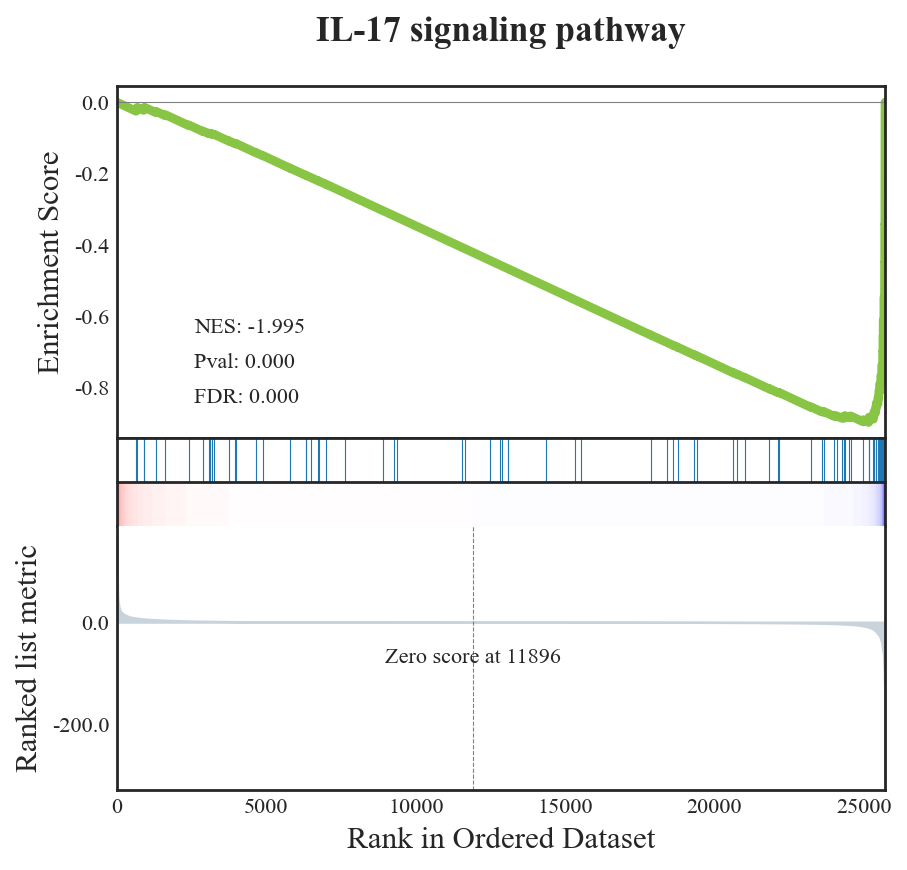

In [58]:
from gseapy.plot import gseaplot

# to save your figure, make sure that ofname is not None
gseaplot(rank_metric=pre_res.ranking, term=terms[0], **pre_res.results[terms[0]])

# Human

In [59]:
tf_human=[]
with open('data/hs_hgnc_tfs.txt') as f:
    for i in f.readlines():
        tf_human.append(i.replace('\n',''))
tf_human[:5]

['HOXA9', 'ZNF8', 'ZNF853', 'NR1H2', 'NR1H3']

In [62]:
nhdf_gsea=pd.read_csv(r'result/NHDF_gsea/prerank_report_kegg/gseapy.prerank.gene_sets.report.csv')
nhdf_gsea=nhdf_gsea.loc[(nhdf_gsea['pval']<0.01) & (nhdf_gsea['fdr']<0.01)]
nhdf_gsea['logp']=-np.log10(nhdf_gsea['pval']+0.001)
nhdf_gsea['com']=nhdf_gsea['matched_size']/nhdf_gsea['geneset_size']
#sc_data.set_index(sc_data.columns[0],inplace=True)
nhdf_gsea.head()

,Term,es,nes,pval,fdr,geneset_size,matched_size,genes,ledge_genes,logp,com
0,IL-17 signaling pathway,-0.896653,-1.995302,0.0,0.000000,93,80,IL17RE;ELAVL1;TRAF4;HSP90AB1;HSP90AA1;IKBKG;IL...,JUN;NFKBIA;CSF2;CEBPB;CSF3;CCL7;JUND;CCL2;CXCL...,3.0,0.860215
1,Protein digestion and absorption,-0.879353,-1.896106,0.0,0.000000,90,80,SLC38A2;SLC8A1;COL13A1;ELN;ATP1B3;COL11A1;COL1...,ATP1A2;COL4A1;COL4A2;SLC7A7;COL21A1;COL14A1;CO...,3.0,0.888889
2,Cytokine-cytokine receptor interaction,-0.757894,-1.814679,0.0,0.006809,294,210,GDF6;TNFRSF12A;TNFRSF10D;IL7R;TGFB2;NGF;CSF1;I...,BMP8B;IL20RB;CCR10;IFNGR1;IL1RN;CXCL11;EPOR;IN...,3.0,0.714286
3,Steroid hormone biosynthesis,-0.902902,-1.812888,0.0,0.007660,60,36,COMT;HSD17B1;STS;LRTOMT;HSD17B6;UGT2B4;UGT1A7;...,AKR1C3;AKR1C2;AKR1C1;HSD11B1;CYP1B1;CYP7B1,3.0,0.600000
4,Proteasome,0.838222,1.906500,0.0,0.009722,45,43,PSMB5;PSMD2;PSMB6;PSMD8;PSMC4;POMP;PSMC2;PSMB4...,PSMB5;PSMD2;PSMB6;PSMD8;PSMC4;POMP;PSMC2;PSMB4...,3.0,0.955556


In [63]:
nhdf_exp=pd.read_csv('data/NEGF_counts.csv')
nhdf_exp=nhdf_exp.set_index(nhdf_exp.columns[0])
ret_index=list(set(pair_human.index.tolist()) & set(nhdf_exp.index.tolist()))
nhdf_exp=nhdf_exp.loc[ret_index]
nhdf_exp['Symbol']=pair_human.loc[ret_index]
nhdf_exp.head()

,NEGF1,NEGF1yuan,NEGF2yuan,NEGF3,NEGF3yuan,Symbol
Geneid,,,,,,
ENSG00000231365,208,269,239,184,267,WARS2-AS1
ENSG00000104497,177,125,100,194,153,SNX16
ENSG00000228118,0,1,1,0,2,MYL6P5
ENSG00000141858,511,666,847,478,702,SAMD1
ENSG00000253755,0,0,0,0,0,IGHGP


In [64]:
nhdf_result=pd.DataFrame(columns=['Term','TF','TF_mean'])
for i in range(len(nhdf_gsea)):
    a1=nhdf_gsea.iloc[i]['ledge_genes'].split(';')
    a2=tf_human
    ret_a=list(set(a1) & set(a2))
    if len(ret_a)!=0:
        ret_exp=[]
        for j in ret_a:
            exp=nhdf_exp.loc[nhdf_exp['Symbol']==j,['NEGF1','NEGF3']].mean(axis=1)/ \
                nhdf_exp.loc[nhdf_exp['Symbol']==j,['NEGF1yuan','NEGF3yuan','NEGF2yuan']].mean(axis=1)
            ret_exp.append(exp.values[0])
        nhdf_result=nhdf_result.append({'Term':nhdf_gsea.iloc[i]['Term'],'TF':ret_a,'TF_mean':np.log2(np.mean(ret_exp))},ignore_index=True)
        
nhdf_result.set_index(nhdf_result.columns[0],inplace=True)

In [65]:
nhdf_result.replace(np.inf,1).to_excel('result/NHDF_TF_Pathway(GSEA).xlsx')
nhdf_result.replace(np.inf,1)

,TF,TF_mean
Term,,
IL-17 signaling pathway,"[CEBPB, JUND, JUN]",0.651795
Cytokine-cytokine receptor interaction,[IL24],7.994353
Proteasome,"[PSMD12, PSMC2]",-0.754526


In [66]:
ec_gsea=pd.read_csv(r'result/EC_gsea/prerank_report_kegg/gseapy.prerank.gene_sets.report.csv')
ec_gsea=ec_gsea.loc[(ec_gsea['pval']<0.01) & (ec_gsea['fdr']<0.01)]
ec_gsea['logp']=-np.log10(ec_gsea['pval']+0.001)
ec_gsea['com']=ec_gsea['matched_size']/ec_gsea['geneset_size']
#sc_data.set_index(sc_data.columns[0],inplace=True)
ec_gsea.head()

,Term,es,nes,pval,fdr,geneset_size,matched_size,genes,ledge_genes,logp,com
0,Cell cycle,0.867944,1.793117,0.0,0.0,124,123,CCNB1;CCND1;PLK1;MCM4;CDC6;CDC20;MCM3;PCNA;MCM...,CCNB1;CCND1;PLK1;MCM4;CDC6;CDC20;MCM3;PCNA;MCM...,3.0,0.991935
1,Neuroactive ligand-receptor interaction,-0.693541,-1.757631,0.0,0.0,338,220,CHRNB1;NMU;CHRNA5;GAL;ADORA2B;ADRB2;TSPO;P2RX5...,NR3C1;NPY1R;LPAR1;OPRL1;LEPR;HTR6;BDKRB2;ADRA2...,3.0,0.650888
2,Nicotine addiction,-0.954443,-1.813116,0.0,0.0,40,25,GRIN2C;CACNA1B;GABRG3;GABRP;GABRR3;GRIN2B;SLC3...,GRIN2D;SLC17A7;GRIN3B,3.0,0.625000
3,RNA transport,0.790156,1.717022,0.0,0.0,165,155,ALYREF;TACC3;EIF4G1;RANGAP1;NUP188;RAN;NUP50;N...,ALYREF;TACC3;EIF4G1;RANGAP1;NUP188;RAN;NUP50;N...,3.0,0.939394
4,Ribosome biogenesis in eukaryotes,0.875752,1.774011,0.0,0.0,101,81,NOP56;DKC1;NOL6;GNL3L;TCOF1;RAN;GNL3;NOP58;POP...,NOP56;DKC1;NOL6;GNL3L;TCOF1;RAN;GNL3;NOP58;POP...,3.0,0.801980


In [67]:
ec_exp=pd.read_csv('data/EC_counts.csv')
ec_exp=ec_exp.set_index(ec_exp.columns[0])
ret_index=list(set(pair_human.index.tolist()) & set(nhdf_exp.index.tolist()))
ec_exp=ec_exp.loc[ret_index]
ec_exp['Symbol']=pair_human.loc[ret_index]
ec_exp.head()

,EC1,EC1yuan,EC2,EC2yuan,EC3,EC3yuan,Symbol
Geneid,,,,,,,
ENSG00000231365,459,293,421,324,457,292,WARS2-AS1
ENSG00000104497,314,148,294,188,311,181,SNX16
ENSG00000228118,0,0,0,0,0,0,MYL6P5
ENSG00000141858,676,798,648,774,697,668,SAMD1
ENSG00000253755,0,0,0,0,0,0,IGHGP


In [68]:
ec_result=pd.DataFrame(columns=['Term','TF','TF_mean'])
for i in range(len(ec_gsea)):
    a1=ec_gsea.iloc[i]['ledge_genes'].split(';')
    a2=tf_human
    ret_a=list(set(a1) & set(a2))
    if len(ret_a)!=0:
        ret_exp=[]
        for j in ret_a:
            exp=ec_exp.loc[ec_exp['Symbol']==j,['EC1','EC2','EC3']].mean(axis=1)/ \
                ec_exp.loc[ec_exp['Symbol']==j,['EC1yuan','EC3yuan','EC2yuan']].mean(axis=1)
            ret_exp.append(exp.values[0])
        ec_result=ec_result.append({'Term':ec_gsea.iloc[i]['Term'],'TF':ret_a,'TF_mean':np.log2(np.mean(ret_exp))},ignore_index=True)
        
ec_result.set_index(ec_result.columns[0],inplace=True)

In [69]:
ec_result.replace(np.inf,1).to_excel('result/HUVEC_TF_Pathway(GSEA).xlsx')
ec_result.replace(np.inf,1)

,TF,TF_mean
Term,,
Cell cycle,"[E2F1, TFDP1, EP300, HDAC1, E2F4, GADD45A, RAD...",-0.818
Neuroactive ligand-receptor interaction,[NR3C1],0.856735
RNA transport,"[NUP133, RAN, MAGOH, DDX20, NUP107]",-0.842925
Ribosome biogenesis in eukaryotes,"[GAR1, RIOK2, UTP18, RAN]",-1.027624
Spliceosome,"[USP39, PQBP1, U2AF1, SNRPB2, HNRNPC, CDC5L, H...",-0.699719
DNA replication,"[POLE3, POLD2, POLE4, RFC2, RFC3]",-1.559443
Proteasome,"[PSMD12, PSMC2]",-0.960812
Oocyte meiosis,"[YWHAZ, SMC3]",-0.607681
Epstein-Barr virus infection,"[E2F1, CYCS, HDAC1, PSMC2, E2F3, E2F2, GADD45A...",-0.942117


In [70]:
plot_nhdf=nhdf_gsea.loc[nhdf_gsea['Term'].isin(nhdf_result.index)]
plot_nhdf['TF']=nhdf_result.loc[plot_nhdf['Term']]['TF'].values
plot_nhdf['TF_mean']=nhdf_result.loc[plot_nhdf['Term']]['TF_mean'].values
plot_nhdf.head()

,Term,es,nes,pval,fdr,geneset_size,matched_size,genes,ledge_genes,logp,com,TF,TF_mean
0,IL-17 signaling pathway,-0.896653,-1.995302,0.0,0.000000,93,80,IL17RE;ELAVL1;TRAF4;HSP90AB1;HSP90AA1;IKBKG;IL...,JUN;NFKBIA;CSF2;CEBPB;CSF3;CCL7;JUND;CCL2;CXCL...,3.0,0.860215,"[CEBPB, JUND, JUN]",0.651795
2,Cytokine-cytokine receptor interaction,-0.757894,-1.814679,0.0,0.006809,294,210,GDF6;TNFRSF12A;TNFRSF10D;IL7R;TGFB2;NGF;CSF1;I...,BMP8B;IL20RB;CCR10;IFNGR1;IL1RN;CXCL11;EPOR;IN...,3.0,0.714286,[IL24],7.994353
4,Proteasome,0.838222,1.906500,0.0,0.009722,45,43,PSMB5;PSMD2;PSMB6;PSMD8;PSMC4;POMP;PSMC2;PSMB4...,PSMB5;PSMD2;PSMB6;PSMD8;PSMC4;POMP;PSMC2;PSMB4...,3.0,0.955556,"[PSMD12, PSMC2]",-0.754526


In [71]:
plot_ec=ec_gsea.loc[ec_gsea['Term'].isin(ec_result.index)]
plot_ec['TF']=ec_result.loc[plot_ec['Term']]['TF'].values
plot_ec['TF_mean']=ec_result.loc[plot_ec['Term']]['TF_mean'].values
plot_ec.head()

,Term,es,nes,pval,fdr,geneset_size,matched_size,genes,ledge_genes,logp,com,TF,TF_mean
0,Cell cycle,0.867944,1.793117,0.0,0.0,124,123,CCNB1;CCND1;PLK1;MCM4;CDC6;CDC20;MCM3;PCNA;MCM...,CCNB1;CCND1;PLK1;MCM4;CDC6;CDC20;MCM3;PCNA;MCM...,3.0,0.991935,"[E2F1, TFDP1, EP300, HDAC1, E2F4, GADD45A, RAD...",-0.818
1,Neuroactive ligand-receptor interaction,-0.693541,-1.757631,0.0,0.0,338,220,CHRNB1;NMU;CHRNA5;GAL;ADORA2B;ADRB2;TSPO;P2RX5...,NR3C1;NPY1R;LPAR1;OPRL1;LEPR;HTR6;BDKRB2;ADRA2...,3.0,0.650888,[NR3C1],0.856735
3,RNA transport,0.790156,1.717022,0.0,0.0,165,155,ALYREF;TACC3;EIF4G1;RANGAP1;NUP188;RAN;NUP50;N...,ALYREF;TACC3;EIF4G1;RANGAP1;NUP188;RAN;NUP50;N...,3.0,0.939394,"[NUP133, RAN, MAGOH, DDX20, NUP107]",-0.842925
4,Ribosome biogenesis in eukaryotes,0.875752,1.774011,0.0,0.0,101,81,NOP56;DKC1;NOL6;GNL3L;TCOF1;RAN;GNL3;NOP58;POP...,NOP56;DKC1;NOL6;GNL3L;TCOF1;RAN;GNL3;NOP58;POP...,3.0,0.801980,"[GAR1, RIOK2, UTP18, RAN]",-1.027624
5,Spliceosome,0.853277,1.792614,0.0,0.0,134,132,ALYREF;HNRNPM;SNRPB;HSPA8;SF3B3;PRPF4;TRA2B;PR...,ALYREF;HNRNPM;SNRPB;HSPA8;SF3B3;PRPF4;TRA2B;PR...,3.0,0.985075,"[USP39, PQBP1, U2AF1, SNRPB2, HNRNPC, CDC5L, H...",-0.699719


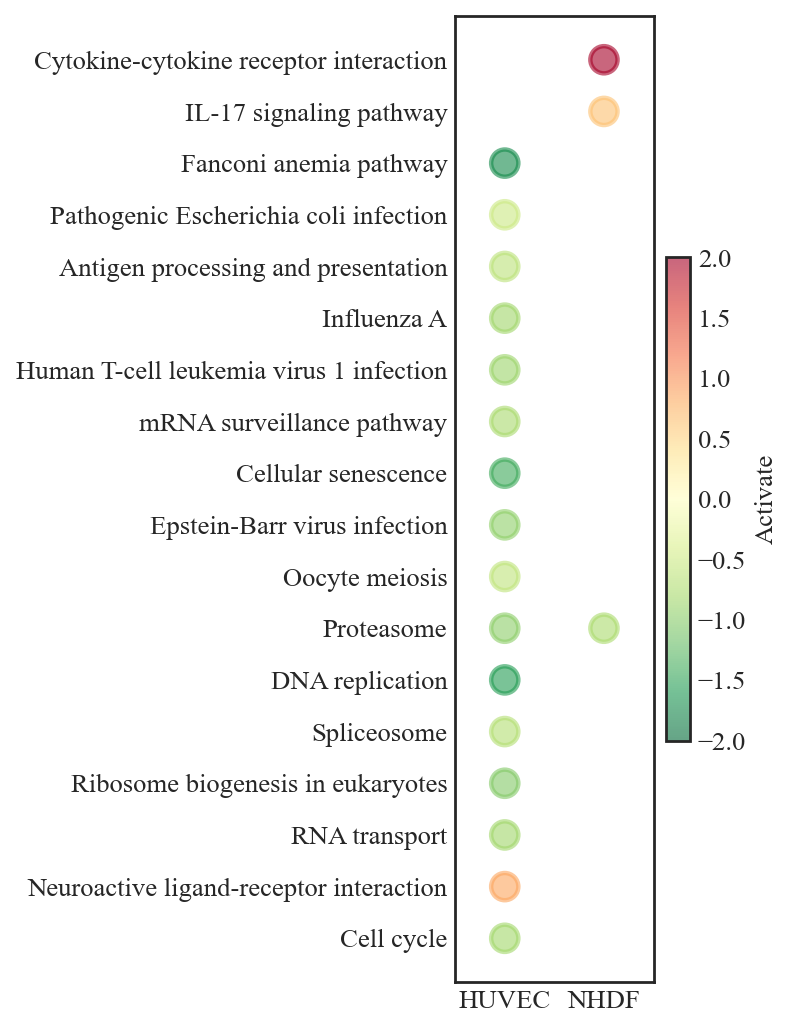

In [72]:
import matplotlib.pyplot as plt
import palettable
pp=plt.figure(figsize=(2,8))
a=pp.add_subplot(1,1,1)
a=plt.scatter(np.zeros(len(plot_ec)),plot_ec['Term'],s=plot_ec['logp']*50,alpha=0.6,linewidth=2,
            c=plot_ec['TF_mean'],vmin=-2,vmax=2,
            cmap='RdYlGn_r')
plt.scatter(np.zeros(len(plot_nhdf))+1,plot_nhdf['Term'],s=plot_nhdf['logp']*50,alpha=0.6,linewidth=2,
            c=plot_nhdf['TF_mean'],vmin=-2,vmax=2,
            cmap='RdYlGn_r')
plt.xticks([0,1],['HUVEC','NHDF'])
plt.xticks(range(-1,3,1))
#plt.colorbar(a)
cb=plt.colorbar(a,shrink=0.5,label='Activate')
#cb=plt.colorbar(label="The amount of Genes",shrink=0.5) 
cb.ax.tick_params(labelsize=12)
#plt.xticks(fontsize=12)
cb.set_label('Activate',fontdict={'size':12,'weight':'normal'})
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.xlim(-0.5,1.5)
plt.savefig('result/human_pathway.png',dpi=300,bbox_inches = 'tight')

# Raw

In [73]:
data1=pd.read_csv('data/RAW_result.csv')
data1=data1.set_index(data1.columns[0])

ret_index=list(set(pair_mouse.index.tolist()) & set(data1.index.tolist()))
data1=data1.loc[ret_index]
data1['Symbol']=pair_mouse.loc[ret_index]['symbol']
data1['Symbol_L']=pair_mouse.loc[ret_index]['symbol_L']

data1['sig'] = 'normal'
data1['log2FoldChange']=-data1['log2FoldChange']
data1.loc[(data1.log2FoldChange> 4 )&(data1.padj < 0.05),'sig'] = 'up'
data1.loc[(data1.log2FoldChange< -4)&(data1.padj < 0.05),'sig'] = 'down'
data1['log(padj)'] = -np.log10(data1['padj'])

data2=data1.copy()
data2.loc[data2['log(padj)']>10,'log(padj)']=10
data2.head()

data1.head()

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,Symbol,Symbol_L,sig,log(padj)
Unnamed: 0,,,,,,,,,,
ENSMUSG00000075145,0.000000,NaN,NaN,NaN,NaN,NaN,Olfr1155,OLFR1155,normal,NaN
ENSMUSG00000025815,0.000000,NaN,NaN,NaN,NaN,NaN,Dhtkd1,DHTKD1,normal,NaN
ENSMUSG00000106794,0.000000,NaN,NaN,NaN,NaN,NaN,Gm40293,GM40293,normal,NaN
ENSMUSG00000028911,520.008477,0.504559,0.094847,-5.319735,1.039185e-07,5.181685e-07,Srsf4,SRSF4,normal,6.285529
ENSMUSG00000084071,17.225455,0.093085,0.504297,-0.184584,8.535551e-01,9.137155e-01,Gm13378,GM13378,normal,0.039189


In [74]:
len(data1.loc[data1['sig']!='normal'])

337

In [76]:
from net_string import *
rnk_gene=data1[data1['sig']!='normal'].index.tolist()
G1=generate_G(rnk_gene,10090)

In [84]:
rt1=string_map(data2[data2['sig']=='up'].index.tolist(),10090)
rt2=string_map(data2[data2['sig']=='down'].index.tolist(),10090)
rt11=rt1['preferredName'].tolist()
rt22=rt2['preferredName'].tolist()
rt111=[i.upper() for i in rt11]
rt222=[i.upper() for i in rt22]

p=dict(G1.nodes)
for i in p.keys():
  if i in rt11:
    p[i]=0
  elif i in rt22:
    p[i]=1
  else:
    p[i]=2

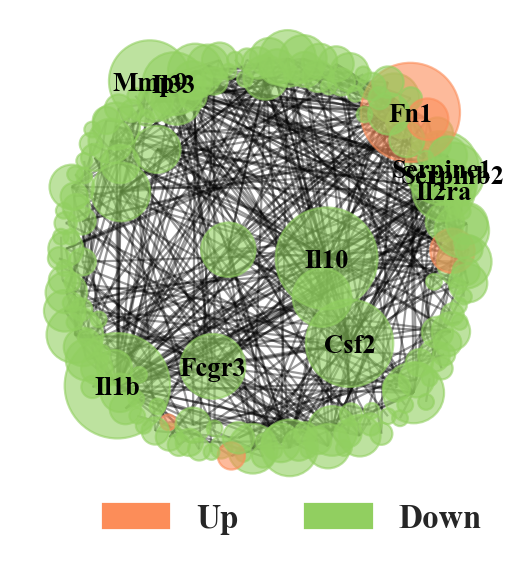

In [85]:
import matplotlib.patches as mpatches
import networkx as nx
np.random.seed(43)
pos = nx.spring_layout(G1, scale=10, k=(len(rnk_gene)//10)/np.sqrt(G1.order()))
d = dict(G1.degree)

plt.figure(figsize=(4, 4))
plt.style.use('seaborn-white')
plt.rc('font', family="Times New Roman")  # 再rc中整体修改plt的风格
nx.draw_networkx_edges(G1, pos, nodelist=[10], alpha=0.4)
degree_dict = dict(G1.degree(G1.nodes()))
#sorted(degree_dict.items(),key=lambda x: x[1],reverse=True)
nx.draw_networkx_nodes(
    G1,
    pos,
    nodelist=list(p.keys()),
    node_size=[degree_dict[v]*50 for v in G1],
    node_color=list(p.values()),
    cmap=c1,
    alpha=0.6,
    linewidths=1,
)

hub_gene=[i[0] for i in sorted(degree_dict.items(),key=lambda x: x[1],reverse=True)[:10]]
pos1=dict()
for i in pos.keys():
  pos1[i]=np.array([-1000,-1000])
for i in hub_gene:
  pos1[i]=pos[i]

nx.draw_networkx_labels(
    G1,pos1,verticalalignment='center_baseline',font_size=12,font_family='Times New Roman',
    font_weight='bold',
)
labels = ['Up', 'Down']  #legend标签列表，上面的color即是颜色列表
#用label和color列表生成mpatches.Patch对象，它将作为句柄来生成legend
color = ['#FC8D59','#91CF60']
patches = [ mpatches.Patch(color=color[i], label="{:s}".format(labels[i]) ) for i in range(len(color)) ] 

#plt.xlim(-0.05, 1.05)
#plt.ylim(-0.05, 1.05)
plt.axis("off")
plt.legend(handles=patches,bbox_to_anchor=(1, 0.05), ncol=3,fontsize=15)
leg = plt.gca().get_legend() #或leg=ax.get_legend()
ltext = leg.get_texts()
plt.setp(ltext, fontsize=15,fontweight='bold')
plt.savefig("result/RAW_network.png",dpi=300,bbox_inches = 'tight')

In [86]:
data1['sig'] = 'normal'
data1.loc[(data1.log2FoldChange> 2 )&(data1.padj < 0.05),'sig'] = 'up'
data1.loc[(data1.log2FoldChange< -2)&(data1.padj < 0.05),'sig'] = 'down'
data1['log(padj)'] = -np.log10(data1['padj'])

data2=data1.copy()
data2.loc[data2['log(padj)']>10,'log(padj)']=10
data2.head()

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,Symbol,Symbol_L,sig,log(padj)
Unnamed: 0,,,,,,,,,,
ENSMUSG00000075145,0.000000,NaN,NaN,NaN,NaN,NaN,Olfr1155,OLFR1155,normal,NaN
ENSMUSG00000025815,0.000000,NaN,NaN,NaN,NaN,NaN,Dhtkd1,DHTKD1,normal,NaN
ENSMUSG00000106794,0.000000,NaN,NaN,NaN,NaN,NaN,Gm40293,GM40293,normal,NaN
ENSMUSG00000028911,520.008477,0.504559,0.094847,-5.319735,1.039185e-07,5.181685e-07,Srsf4,SRSF4,normal,6.285529
ENSMUSG00000084071,17.225455,0.093085,0.504297,-0.184584,8.535551e-01,9.137155e-01,Gm13378,GM13378,normal,0.039189


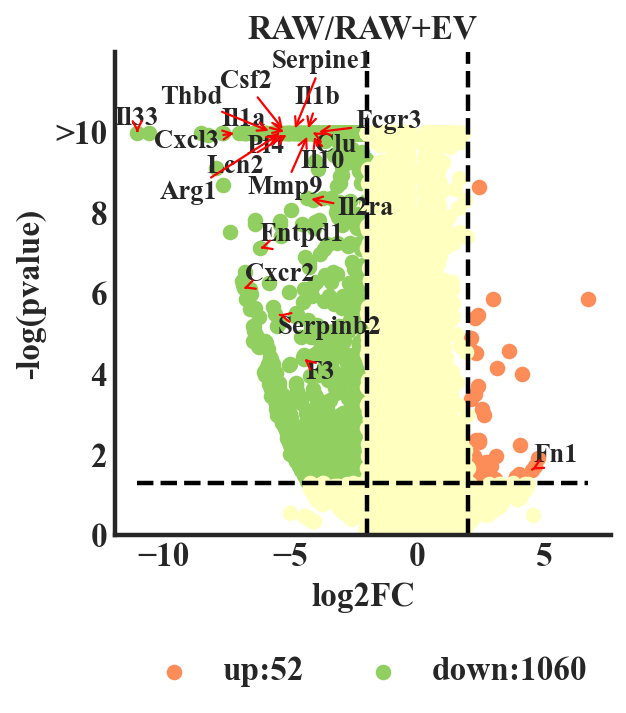

In [87]:
font1={
    'font':'Times New Roman',
    'weight':'bold',
    'size':15,
}
pp=plt.figure(figsize=(4,4))
ax=pp.add_subplot(1,1,1)
plt.scatter(x=data2[data2['sig']=='up']['log2FoldChange'],y=data2[data1['sig']=='up']['log(padj)'],color='#FC8D59',label='up')
plt.scatter(x=data2[data2['sig']=='down']['log2FoldChange'],y=data2[data1['sig']=='down']['log(padj)'],color='#91CF60',label='down')
plt.scatter(x=data2[data2['sig']=='normal']['log2FoldChange'],y=data2[data1['sig']=='normal']['log(padj)'],color='#FFFFBF',label='normal')

plt.yticks([0,2,4,6,8,10,12],['0','2','4','6','8','>10',''],fontsize=15,fontweight='bold')
plt.xticks(fontsize=15,fontweight='bold')
plt.ylim(0,12)
#plt.xlim(-10,10)
#plt.legend(loc='best',fontsize=15)
hub_gene=[i[0] for i in sorted(degree_dict.items(),key=lambda x: x[1],reverse=True)[:20]]
#hub_gene=['Atp5b','Atp5o','Atp5j','Hsp90aa1','Hspe1','Eif4a1','Eef1b2','Eif5a','Rplp0','Rpsa','Rps3a1','Rps14','Rpl15','Rpl13','Rpl22']
test=hub_gene
texts=[plt.text(data2[data2['Symbol']==i]['log2FoldChange'].values[0], data2[data2['Symbol']==i]['log(padj)'].values[0],
        i
        ,fontdict={'size':12,'weight':'bold'}) for i in test[:20]]

adjust_text(texts,only_move={'text': 'xy'},arrowprops=dict(arrowstyle='->', color='red'),)


plt.legend(['up:{0}'.format(len(data2[data2['sig']=='up'])),
      'down:{0}'.format(len(data2[data2['sig']=='down']))],bbox_to_anchor=(1, -0.2), ncol=2,fontsize=12)
leg = plt.gca().get_legend() #或leg=ax.get_legend()
ltext = leg.get_texts()
plt.setp(ltext, fontsize=15,fontweight='bold')

ax.set_ylabel('-log(pvalue)',font1)                                    
ax.set_xlabel('log2FC',font1)
ax.plot([data1['log2FoldChange'].min(),data1['log2FoldChange'].max()],[-np.log10(0.05),-np.log10(0.05)],linewidth=2, linestyle="--",color='black')
ax.plot([2,2],[data1['log(padj)'].min(),300],linewidth=2, linestyle="--",color='black')
ax.plot([-2,-2],[data1['log(padj)'].min(),300],linewidth=2, linestyle="--",color='black')
plt.title('RAW/RAW+EV',fontsize=15,fontweight='bold')

#绘制图像标题
ax=plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_linewidth(2);###设置底部坐标轴的粗细
ax.spines['left'].set_linewidth(2);####设置左边坐标轴的粗细
ax.spines['right'].set_linewidth(2);###设置右边坐标轴的粗细
ax.spines['top'].set_linewidth(2);####设置上部坐标轴的粗细

plt.savefig("result/RAW_volcano.png",dpi=300,bbox_inches = 'tight')
#plt.savefig("HVUEC_volcano.png",dpi=300,bbox_inches = 'tight')

In [88]:
data=pd.read_csv('data/RAW_counts.csv')
data=data.set_index(data.columns[0])
data.head()

,RAW1,RAW1yuan,RAW2,RAW2yuan,RAW3,RAW3yuan
Geneid,,,,,,
ENSMUSG00000102693,0,0,0,0,0,0
ENSMUSG00000064842,0,0,0,0,0,0
ENSMUSG00000051951,0,0,0,0,0,0
ENSMUSG00000102851,0,0,0,0,0,0
ENSMUSG00000103377,0,0,0,0,0,0


In [90]:
RAW_heatmap_data=data.loc[rnk_gene]
RAW_heatmap_data.index=data1.loc[rnk_gene]['Symbol'].tolist()
RAW_heatmap_data.head()

,RAW1,RAW1yuan,RAW2,RAW2yuan,RAW3,RAW3yuan
Gm20442,59,6,61,0,36,3
Gm44223,4,0,9,0,7,1
Gm48038,6,0,7,0,8,0
Lbp,10,0,27,2,15,0
Mmp25,11,0,17,1,17,0


In [95]:
help(sns.clustermap)

Help on function clustermap in module seaborn.matrix:

clustermap(data, *, pivot_kws=None, method='average', metric='euclidean', z_score=None, standard_scale=None, figsize=(10, 10), cbar_kws=None, row_cluster=True, col_cluster=True, row_linkage=None, col_linkage=None, row_colors=None, col_colors=None, mask=None, dendrogram_ratio=0.2, colors_ratio=0.03, cbar_pos=(0.02, 0.8, 0.05, 0.18), tree_kws=None, **kwargs)
    Plot a matrix dataset as a hierarchically-clustered heatmap.
    
    Parameters
    ----------
    data : 2D array-like
        Rectangular data for clustering. Cannot contain NAs.
    pivot_kws : dict, optional
        If `data` is a tidy dataframe, can provide keyword arguments for
        pivot to create a rectangular dataframe.
    method : str, optional
        Linkage method to use for calculating clusters. See
        :func:`scipy.cluster.hierarchy.linkage` documentation for more
        information.
    metric : str, optional
        Distance metric to use for the da

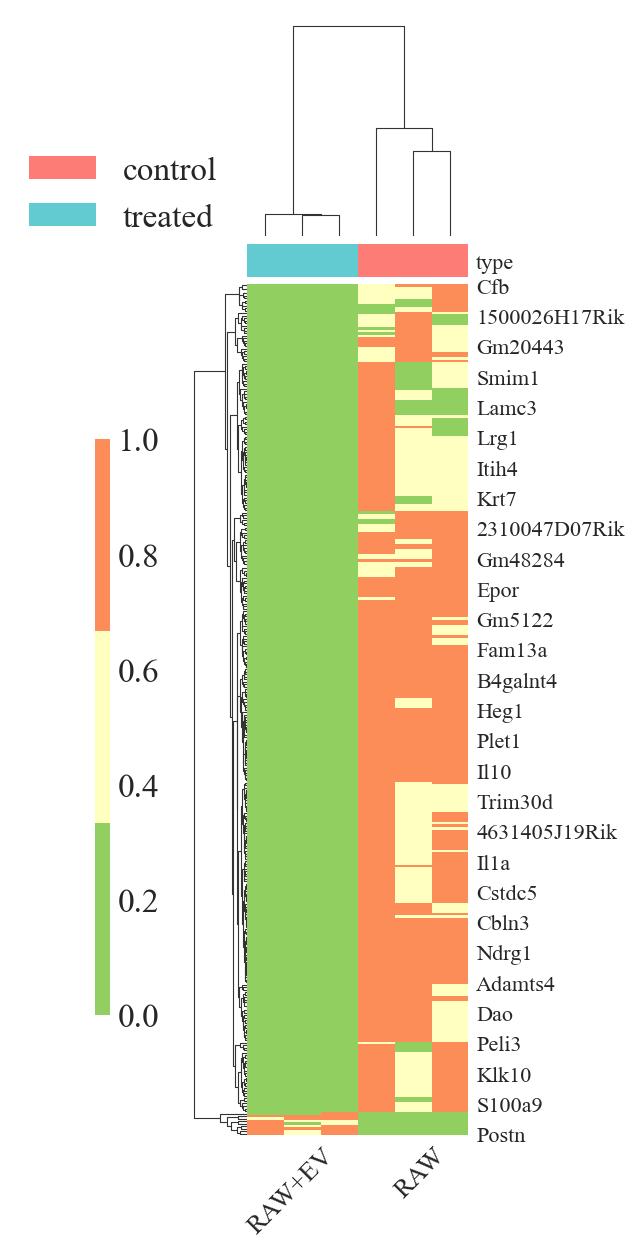

In [94]:
import palettable
meta=pd.read_csv('data/RAW_meta.csv')
meta=meta.set_index(meta.columns[0])
col_c={
    'control':'#FD7C76',
    'treated':'#62CAD1'
}

a=sns.clustermap(RAW_heatmap_data, 
               cmap=palettable.colorbrewer.diverging.RdYlGn_3_r.mpl_colors, 
               standard_scale = 0,figsize=(3,8),
              col_colors=meta['type'].map(col_c),
)
a.ax_heatmap.yaxis.set_tick_params(labelsize=10)
a.ax_heatmap.xaxis.set_tick_params(labelsize=12)
a.ax_heatmap.xaxis.set_ticklabels(['','','RAW+EV','','','RAW'])
labels=a.ax_heatmap.xaxis.get_ticklabels()
#a.ax_heatmap.xaxis.set_text(['','RAW','','','RAW+EV',''])
plt.setp(labels, rotation=45, horizontalalignment='right',)
for label in meta['type'].unique():
    a.ax_col_dendrogram.bar(0, 0, color=col_c[label],
                            label=label, linewidth=0)
a.ax_col_dendrogram.legend(loc="best", ncol=1,bbox_to_anchor=(-0.5, 0., 0.5, 0.5),fontsize=15)
a.cax.set_position([-.15, .2, .03, .45])
plt.setp(a.cax.yaxis.get_majorticklabels(), fontsize=15)
plt.savefig("result/RAW_heatmap.png",dpi=300,bbox_inches = 'tight')
#plt.savefig("HVUEC_heatmap.png",dpi=300,bbox_inches = 'tight')

In [96]:
enr = gp.enrichr(gene_list=RAW_heatmap_data.index.tolist(),
    gene_sets='KEGG_2019_Mouse',
    organism='Mouse', # don't forget to set organism to the one you desired! e.g. Yeast
    description='description',
    outdir='result/enrichment_KEGG_RAW',
     # no_plot=True,
    cutoff=0.5 # test dataset, use lower value from range(0,1)
)
#subp=dotplot(enr.res2d, title=description,cmap='seismic')
#print(subp)
enr.res2d.head()

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,KEGG_2019_Mouse,Complement and coagulation cascades,12/88,2.810917e-08,0.000006,0,0,9.515951,165.455464,THBD;C1S2;C1S1;SERPINB2;F10;SERPINE1;BDKRB2;BD...
1,KEGG_2019_Mouse,Cytokine-cytokine receptor interaction,20/292,1.313114e-07,0.000013,0,0,4.497820,71.271073,IL10;CCL24;IL33;CSF2;TNFSF15;IL34;TNFRSF9;LIF;...
2,KEGG_2019_Mouse,IL-17 signaling pathway,7/91,8.738452e-04,0.058839,0,0,4.944192,34.820002,CSF2;IL1B;LCN2;CXCL3;MMP9;S100A9;S100A8
3,KEGG_2019_Mouse,AGE-RAGE signaling pathway in diabetic complic...,7/101,1.610059e-03,0.081308,0,0,4.415957,28.401162,THBD;IL1A;COL1A2;IL1B;SERPINE1;FN1;F3
4,KEGG_2019_Mouse,Amoebiasis,7/106,2.124545e-03,0.085832,0,0,4.191858,25.797522,IL10;CSF2;COL1A2;LAMC3;ARG1;IL1B;FN1


In [97]:
kegg_result_raw=enr.res2d[enr.res2d['P-value']<0.05]
kegg_result_raw['logp']=-np.log(kegg_result_raw['Adjusted P-value'])
kegg_result_raw['logc']=np.log(kegg_result_raw['Combined Score'])
kegg_result_raw['num']=[int(i.split('/')[0]) for i in kegg_result_raw['Overlap']]

In [98]:
def plot_text_set(text):
  if len(text)>10:
    t=text.split(' ')
    n=0
    res=''
    for i in t:
      if n==0:
        res=i 
      else:
        res=res+'\n'+i
      n+=1
    return res
  else:
    return text

In [99]:
kegg_result_raw.to_excel('result/RAW_KEGG_pathway(normal).xlsx')

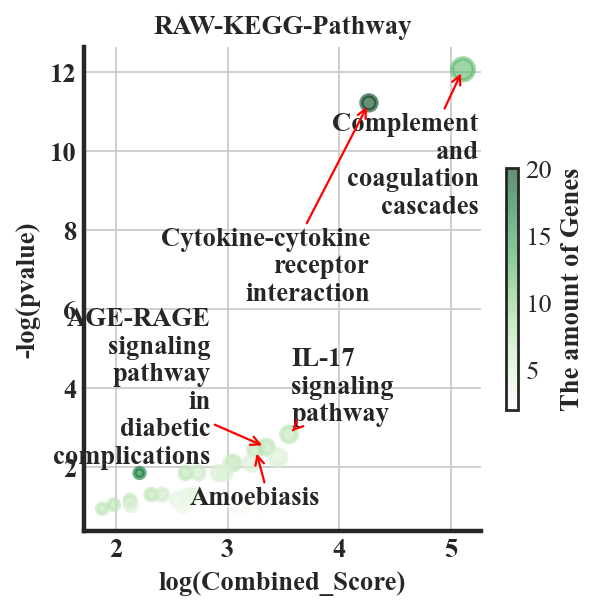

In [100]:
pp=plt.figure(figsize=(4,4))
#用ax控制图片
ax=pp.add_subplot(1,1,1)

plt.scatter(kegg_result_raw['logc'],kegg_result_raw['logp'],
      s=kegg_result_raw['Odds Ratio']*10,c=kegg_result_raw['num'],cmap='Greens',alpha=0.6,linewidth=2,)

test=kegg_result_raw['Term'].values
texts=[plt.text(kegg_result_raw[kegg_result_raw['Term']==i]['logc'].values[0], kegg_result_raw[kegg_result_raw['Term']==i]['logp'].values[0],
        plot_text_set(i)
        ,fontdict={'size':12,'weight':'bold'}) for i in test[:5]]

adjust_text(texts,only_move={'text': 'xy'},arrowprops=dict(arrowstyle='->', color='red'),)


#plt.annotate(me_result.index[0], xy=(me_result['Impact'][0],me_result['-log10(p)'][0]), xytext=(0.2,2),
#bbox=dict(boxstyle='round,pad=0.3', fc='white', alpha=0.5),arrowprops=dict(arrowstyle='-',color='black'),size=15)

#plt.annotate(me_result.index[1], xy=(me_result['Impact'][1],me_result['-log10(p)'][1]), xytext=(0.2,1.5),
#bbox=dict(boxstyle='round,pad=0.3', fc='white', alpha=0.5),arrowprops=dict(arrowstyle='-',color='black'),size=15)

#plt.annotate(me_result.index[2], xy=(me_result['Impact'][2],me_result['-log10(p)'][2]), xytext=(0.2,1),
#bbox=dict(boxstyle='round,pad=0.3', fc='white', alpha=0.5),arrowprops=dict(arrowstyle='-',color='black'),size=15)

#设置横纵坐标轴字体
plt.yticks(fontsize=12,fontweight='bold')
plt.xticks(fontsize=12,fontweight='bold')
#设置图注
#plt.legend(loc='center right', bbox_to_anchor=(0, -.5), ncol=3,fontsize=12)
#设置横纵标题
plt.ylabel('-log(pvalue)',fontsize=12,fontweight='bold')                   
plt.xlabel('log(Combined_Score)',fontsize=12,fontweight='bold')
plt.title('RAW-KEGG-Pathway',fontsize=12,fontweight='bold')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_linewidth(2);###设置底部坐标轴的粗细
ax.spines['left'].set_linewidth(2);####设置左边坐标轴的粗细
ax.spines['right'].set_linewidth(2);###设置右边坐标轴的粗细
ax.spines['top'].set_linewidth(2);####设置上部坐标轴的粗细

cb=plt.colorbar(label="The amount of Genes",shrink=0.5) 
cb.ax.tick_params(labelsize=12)
#plt.xticks(fontsize=12)
plt.grid(None)
cb.set_label('The amount of Genes',fontdict={'size':12,'weight':'bold'})
#plt.savefig("kegg_ad.png",dpi=300,bbox_inches = 'tight')
plt.savefig("result/RAW_kegg.png",dpi=300,bbox_inches = 'tight')

## gsea

In [101]:
gseada=data1.loc[data1['sig']!='normal']
gseada=data1
gseada['fcsign']=-np.sign(gseada['log2FoldChange'])
gseada['logp']=-np.log10(gseada['pvalue'])
gseada['metric']=gseada['logp']/gseada['fcsign']
gseada.head()

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,Symbol,Symbol_L,sig,log(padj),fcsign,logp,metric
Unnamed: 0,,,,,,,,,,,,,
ENSMUSG00000075145,0.000000,NaN,NaN,NaN,NaN,NaN,Olfr1155,OLFR1155,normal,NaN,NaN,NaN,NaN
ENSMUSG00000025815,0.000000,NaN,NaN,NaN,NaN,NaN,Dhtkd1,DHTKD1,normal,NaN,NaN,NaN,NaN
ENSMUSG00000106794,0.000000,NaN,NaN,NaN,NaN,NaN,Gm40293,GM40293,normal,NaN,NaN,NaN,NaN
ENSMUSG00000028911,520.008477,0.504559,0.094847,-5.319735,1.039185e-07,5.181685e-07,Srsf4,SRSF4,normal,6.285529,-1.0,6.983307,-6.983307
ENSMUSG00000084071,17.225455,0.093085,0.504297,-0.184584,8.535551e-01,9.137155e-01,Gm13378,GM13378,normal,0.039189,-1.0,0.068768,-0.068768


In [102]:
gseada=gseada.sort_values(by=['metric'],ascending=False)
gseada.head()

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,Symbol,Symbol_L,sig,log(padj),fcsign,logp,metric
Unnamed: 0,,,,,,,,,,,,,
ENSMUSG00000069833,4695.618211,-3.112015,0.067384,46.183220,0.0,0.0,Ahnak,AHNAK,down,inf,1.0,inf,inf
ENSMUSG00000025130,25285.710752,-1.630207,0.040164,40.588372,0.0,0.0,P4hb,P4HB,normal,inf,1.0,inf,inf
ENSMUSG00000003541,6845.531766,-2.311087,0.051495,44.879876,0.0,0.0,Ier3,IER3,down,inf,1.0,inf,inf
ENSMUSG00000037820,1132.466506,-5.491538,0.140928,38.967049,0.0,0.0,Tgm2,TGM2,down,inf,1.0,inf,inf
ENSMUSG00000026981,1901.235214,-3.753545,0.095562,39.278640,0.0,0.0,Il1rn,IL1RN,down,inf,1.0,inf,inf


In [103]:
rnk=pd.DataFrame()
rnk['gene_name']=gseada.index
rnk['rnk']=gseada['metric'].values
k=1
total=0
for i in range(len(rnk)):
    if rnk.loc[i,'rnk']==np.inf: 
        total+=1

for i in range(len(rnk)):
    if rnk.loc[i,'rnk']==np.inf: 
        rnk.loc[i,'rnk']=307+(total-k)
        k+=1
    elif rnk.loc[i,'rnk']==-np.inf: 
        rnk.loc[i,'rnk']=-(300+k)
        k+=1
#rnk=rnk.replace(np.inf,300)
#rnk=rnk.replace(-np.inf,-300)
rnk['gene_name']=gseada['Symbol_L'].tolist()
rnk=rnk.dropna()
rnk.head()

,gene_name,rnk
0,AHNAK,315.0
1,P4HB,314.0
2,IER3,313.0
3,TGM2,312.0
4,IL1RN,311.0


In [104]:
pre_res = gp.prerank(rnk=rnk, gene_sets='KEGG_2019_Mouse',
                     processes=16,
                     permutation_num=100, # reduce number to speed up testing
                     outdir='result/RAW_gsea/prerank_report_kegg', format='png', seed=6)

2022-06-22 19:46:58,292 Input gene rankings contains duplicated IDs, Only use the duplicated ID with highest value!


In [105]:
pre_res.res2d.head()

,es,nes,pval,fdr,geneset_size,matched_size,genes,ledge_genes
Term,,,,,,,,
Complement and coagulation cascades,0.880971,1.673290,0.0,0.0,88,65,SERPINE1;ITGAM;C3AR1;PLAU;C5AR1;CLU;C3;BDKRB2;...,SERPINE1;ITGAM;C3AR1;PLAU;C5AR1;CLU;C3;BDKRB2;...
Cytokine-cytokine receptor interaction,0.835920,1.718526,0.0,0.0,292,204,IL1RN;IL10RA;TNFRSF9;CXCL2;LIF;CCL4;IL13RA1;IL...,IL1RN;IL10RA;TNFRSF9;CXCL2;LIF;CCL4;IL13RA1;IL...
HIF-1 signaling pathway,0.855529,1.685912,0.0,0.0,104,99,VEGFA;PFKFB3;SERPINE1;ENO2;SLC2A1;EGLN1;HK1;PD...,VEGFA;PFKFB3;SERPINE1;ENO2;SLC2A1;EGLN1;HK1;PD...
Neuroactive ligand-receptor interaction,0.826257,1.717454,0.0,0.0,348,192,GIPR;THRA;ADM;C3AR1;C5AR1;C3;BDKRB2;GPR35;TSPO...,GIPR;THRA;ADM;C3AR1;C5AR1;C3;BDKRB2;GPR35;TSPO...
RNA transport,-0.782943,-1.987347,0.0,0.0,167,155,EIF4EBP1;CYFIP1;CYFIP2;EIF1B;ELAC1;SNUPN;EIF2S...,ALYREF2;RPP40;EIF3F;TGS1;EIF2S3X;NUP50;EIF2B3;...


In [106]:
# extract geneset terms in res2d
terms = pre_res.res2d.index
terms

Index(['Complement and coagulation cascades',
       'Cytokine-cytokine receptor interaction', 'HIF-1 signaling pathway',
       'Neuroactive ligand-receptor interaction', 'RNA transport', 'Ribosome',
       'Ribosome biogenesis in eukaryotes', 'Spliceosome',
       'Staphylococcus aureus infection', 'mRNA surveillance pathway',
       ...
       'Phenylalanine metabolism', 'N-Glycan biosynthesis',
       'Lysine degradation',
       'Glycosylphosphatidylinositol (GPI)-anchor biosynthesis',
       'Porphyrin and chlorophyll metabolism', 'Tyrosine metabolism',
       'Pentose and glucuronate interconversions',
       'Steroid hormone biosynthesis', 'Folate biosynthesis',
       'Phototransduction'],
      dtype='object', name='Term', length=286)

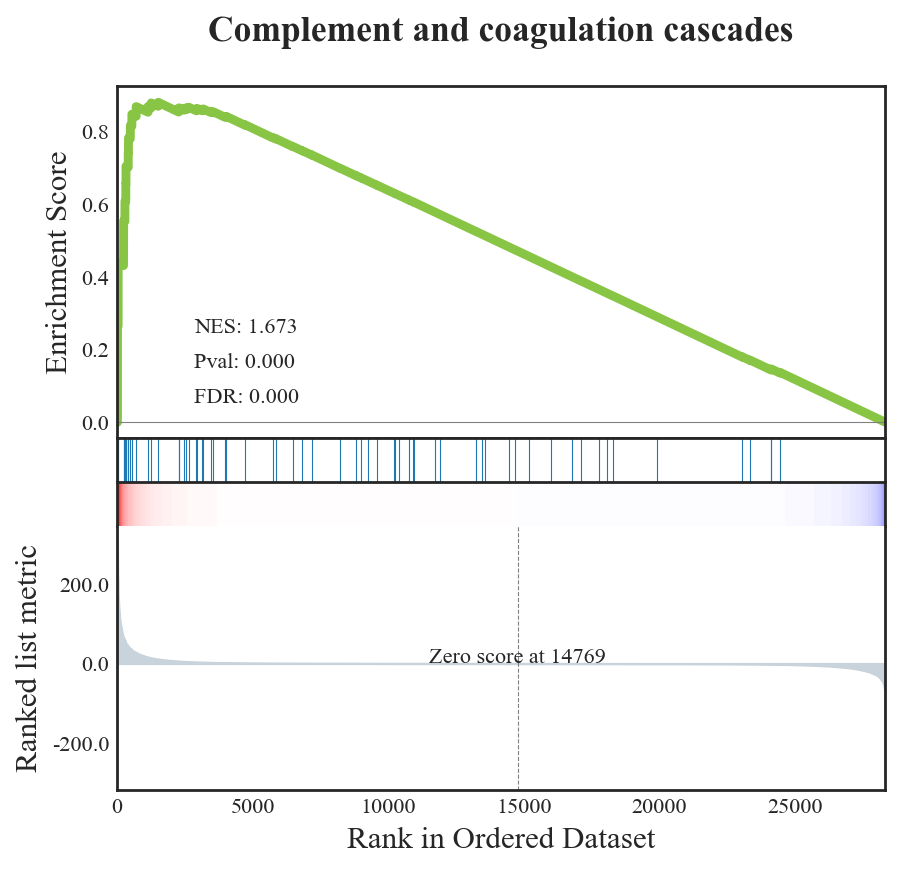

In [107]:
from gseapy.plot import gseaplot

# to save your figure, make sure that ofname is not None
gseaplot(rank_metric=pre_res.ranking, term=terms[0], **pre_res.results[terms[0]])

# SC

In [108]:
data1=pd.read_csv('data/SC_result.csv')
data1=data1.set_index(data1.columns[0])

ret_index=list(set(pair_mouse.index.tolist()) & set(data1.index.tolist()))
data1=data1.loc[ret_index]
data1['Symbol']=pair_mouse.loc[ret_index]['symbol']
data1['Symbol_L']=pair_mouse.loc[ret_index]['symbol_L']

data1['sig'] = 'normal'
data1.loc[(data1.log2FoldChange> 2 )&(data1.padj < 0.05),'sig'] = 'up'
data1.loc[(data1.log2FoldChange< -2)&(data1.padj < 0.05),'sig'] = 'down'
data1['log(padj)'] = -np.log10(data1['padj'])

data2=data1.copy()
data2.loc[data2['log(padj)']>10,'log(padj)']=10
data2.head()

data1.head()

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,Symbol,Symbol_L,sig,log(padj)
Unnamed: 0,,,,,,,,,,
ENSMUSG00000075145,0.000000,NaN,NaN,NaN,NaN,NaN,Olfr1155,OLFR1155,normal,NaN
ENSMUSG00000025815,25.034085,-0.142977,2.527035,-0.056579,0.954881,0.978500,Dhtkd1,DHTKD1,normal,0.009439
ENSMUSG00000106794,0.000000,NaN,NaN,NaN,NaN,NaN,Gm40293,GM40293,normal,NaN
ENSMUSG00000028911,499.367487,-0.435374,0.791461,-0.550089,0.582258,0.798255,Srsf4,SRSF4,normal,0.097859
ENSMUSG00000084071,4.129948,5.038713,2.955128,1.705074,0.088181,NaN,Gm13378,GM13378,normal,NaN


In [109]:
len(data1.loc[data1['sig']!='normal'])

154

In [112]:
from net_string import *
rnk_gene=data1[data1['sig']!='normal'].index.tolist()
G1=generate_G(rnk_gene,10090)

In [113]:
rt1=string_map(data2[data2['sig']=='up'].index.tolist(),10090)
rt2=string_map(data2[data2['sig']=='down'].index.tolist(),10090)
rt11=rt1['preferredName'].tolist()
rt22=rt2['preferredName'].tolist()
rt111=[i.upper() for i in rt11]
rt222=[i.upper() for i in rt22]

p=dict(G1.nodes)
for i in p.keys():
  if i in rt11:
    p[i]=0
  elif i in rt22:
    p[i]=1
  else:
    p[i]=2

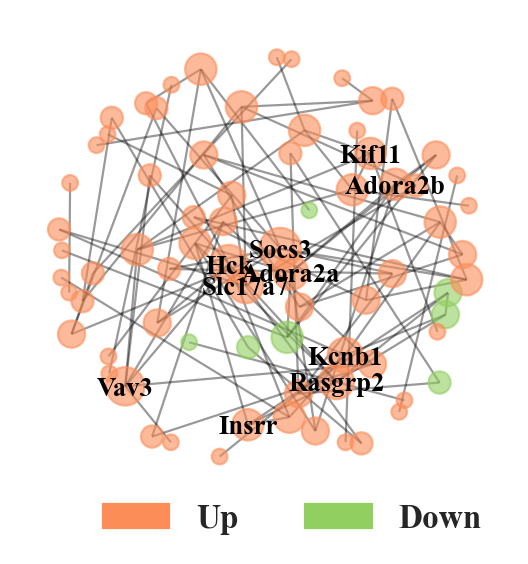

In [114]:
import matplotlib.patches as mpatches
import networkx as nx
np.random.seed(6)
pos = nx.spring_layout(G1, scale=10, k=(len(rnk_gene)//15)/np.sqrt(G1.order()))
d = dict(G1.degree)

plt.figure(figsize=(4, 4))
plt.style.use('seaborn-white')
plt.rc('font', family="Times New Roman")  # 再rc中整体修改plt的风格
nx.draw_networkx_edges(G1, pos, nodelist=[10], alpha=0.4)
degree_dict = dict(G1.degree(G1.nodes()))
#sorted(degree_dict.items(),key=lambda x: x[1],reverse=True)
nx.draw_networkx_nodes(
    G1,
    pos,
    nodelist=list(p.keys()),
    node_size=[degree_dict[v]*50 for v in G1],
    node_color=list(p.values()),
    cmap=c1,
    alpha=0.6,
    linewidths=1,
)

hub_gene=[i[0] for i in sorted(degree_dict.items(),key=lambda x: x[1],reverse=True)[:10]]
pos1=dict()
for i in pos.keys():
  pos1[i]=np.array([-1000,-1000])
for i in hub_gene:
  pos1[i]=pos[i]

nx.draw_networkx_labels(
    G1,pos1,verticalalignment='center_baseline',font_size=12,font_family='Times New Roman',
    font_weight='bold',
)
labels = ['Up', 'Down']  #legend标签列表，上面的color即是颜色列表
#用label和color列表生成mpatches.Patch对象，它将作为句柄来生成legend
color = ['#FC8D59','#91CF60']
patches = [ mpatches.Patch(color=color[i], label="{:s}".format(labels[i]) ) for i in range(len(color)) ] 

#plt.xlim(-0.05, 1.05)
#plt.ylim(-0.05, 1.05)
plt.axis("off")
plt.legend(handles=patches,bbox_to_anchor=(1, 0.05), ncol=3,fontsize=15)
leg = plt.gca().get_legend() #或leg=ax.get_legend()
ltext = leg.get_texts()
plt.setp(ltext, fontsize=15,fontweight='bold')
plt.savefig("result/SC_network.png",dpi=300,bbox_inches = 'tight')

In [115]:
data1['sig'] = 'normal'
data1.loc[(data1.log2FoldChange> 2 )&(data1.padj < 0.05),'sig'] = 'up'
data1.loc[(data1.log2FoldChange< -2)&(data1.padj < 0.05),'sig'] = 'down'
data1['log(padj)'] = -np.log10(data1['padj'])

data2=data1.copy()
data2.loc[data2['log(padj)']>10,'log(padj)']=10
data2.head()

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,Symbol,Symbol_L,sig,log(padj)
Unnamed: 0,,,,,,,,,,
ENSMUSG00000075145,0.000000,NaN,NaN,NaN,NaN,NaN,Olfr1155,OLFR1155,normal,NaN
ENSMUSG00000025815,25.034085,-0.142977,2.527035,-0.056579,0.954881,0.978500,Dhtkd1,DHTKD1,normal,0.009439
ENSMUSG00000106794,0.000000,NaN,NaN,NaN,NaN,NaN,Gm40293,GM40293,normal,NaN
ENSMUSG00000028911,499.367487,-0.435374,0.791461,-0.550089,0.582258,0.798255,Srsf4,SRSF4,normal,0.097859
ENSMUSG00000084071,4.129948,5.038713,2.955128,1.705074,0.088181,NaN,Gm13378,GM13378,normal,NaN


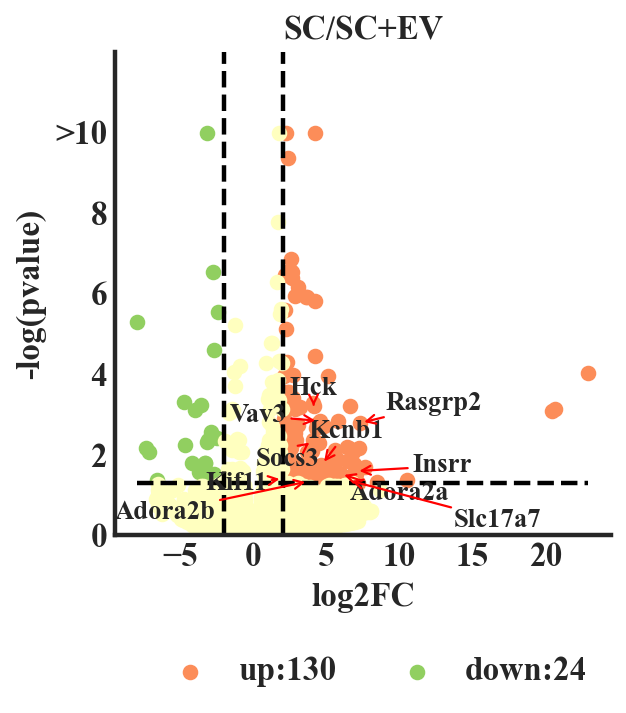

In [116]:
font1={
    'font':'Times New Roman',
    'weight':'bold',
    'size':15,
}
pp=plt.figure(figsize=(4,4))
ax=pp.add_subplot(1,1,1)
plt.scatter(x=data2[data2['sig']=='up']['log2FoldChange'],y=data2[data1['sig']=='up']['log(padj)'],color='#FC8D59',label='up')
plt.scatter(x=data2[data2['sig']=='down']['log2FoldChange'],y=data2[data1['sig']=='down']['log(padj)'],color='#91CF60',label='down')
plt.scatter(x=data2[data2['sig']=='normal']['log2FoldChange'],y=data2[data1['sig']=='normal']['log(padj)'],color='#FFFFBF',label='normal')

plt.yticks([0,2,4,6,8,10,12],['0','2','4','6','8','>10',''],fontsize=15,fontweight='bold')
plt.xticks(fontsize=15,fontweight='bold')
plt.ylim(0,12)
#plt.xlim(-10,10)
#plt.legend(loc='best',fontsize=15)
hub_gene=[i[0] for i in sorted(degree_dict.items(),key=lambda x: x[1],reverse=True)[:20]]
#hub_gene=['Atp5b','Atp5o','Atp5j','Hsp90aa1','Hspe1','Eif4a1','Eef1b2','Eif5a','Rplp0','Rpsa','Rps3a1','Rps14','Rpl15','Rpl13','Rpl22']
test=hub_gene
texts=[plt.text(data2[data2['Symbol']==i]['log2FoldChange'].values[0], data2[data2['Symbol']==i]['log(padj)'].values[0],
        i
        ,fontdict={'size':12,'weight':'bold'}) for i in test[:10]]

adjust_text(texts,only_move={'text': 'xy'},arrowprops=dict(arrowstyle='->', color='red'),)


plt.legend(['up:{0}'.format(len(data2[data2['sig']=='up'])),
      'down:{0}'.format(len(data2[data2['sig']=='down']))],bbox_to_anchor=(1, -0.2), ncol=2,fontsize=12)
leg = plt.gca().get_legend() #或leg=ax.get_legend()
ltext = leg.get_texts()
plt.setp(ltext, fontsize=15,fontweight='bold')

ax.set_ylabel('-log(pvalue)',font1)                                    
ax.set_xlabel('log2FC',font1)
ax.plot([data1['log2FoldChange'].min(),data1['log2FoldChange'].max()],[-np.log10(0.05),-np.log10(0.05)],linewidth=2, linestyle="--",color='black')
ax.plot([2,2],[data1['log(padj)'].min(),300],linewidth=2, linestyle="--",color='black')
ax.plot([-2,-2],[data1['log(padj)'].min(),300],linewidth=2, linestyle="--",color='black')
plt.title('SC/SC+EV',fontsize=15,fontweight='bold')

#绘制图像标题
ax=plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_linewidth(2);###设置底部坐标轴的粗细
ax.spines['left'].set_linewidth(2);####设置左边坐标轴的粗细
ax.spines['right'].set_linewidth(2);###设置右边坐标轴的粗细
ax.spines['top'].set_linewidth(2);####设置上部坐标轴的粗细

plt.savefig("result/SC_volcano.png",dpi=300,bbox_inches = 'tight')
#plt.savefig("HVUEC_volcano.png",dpi=300,bbox_inches = 'tight')

In [117]:
data=pd.read_csv('data/SC_counts.csv')
data=data.set_index(data.columns[0])
data.head()

,SC2,SC2yuan,SC3,SC3yuan
Geneid,,,,
ENSMUSG00000102693,0,0,0,0
ENSMUSG00000064842,0,0,0,0
ENSMUSG00000051951,0,0,0,0
ENSMUSG00000102851,0,0,0,0
ENSMUSG00000103377,0,0,0,0


In [118]:
SC_heatmap_data=data.loc[rnk_gene]
SC_heatmap_data.index=data1.loc[rnk_gene]['Symbol'].tolist()
SC_heatmap_data=SC_heatmap_data.loc[SC_heatmap_data.sum(axis=1)!=0]
SC_heatmap_data.head()

,SC2,SC2yuan,SC3,SC3yuan
Efna1,286,8,303,5
Adora2b,134,11,156,2
Pear1,620,40,581,58
Wnk2,67,6,77,1
Nfil3,618,25,531,18


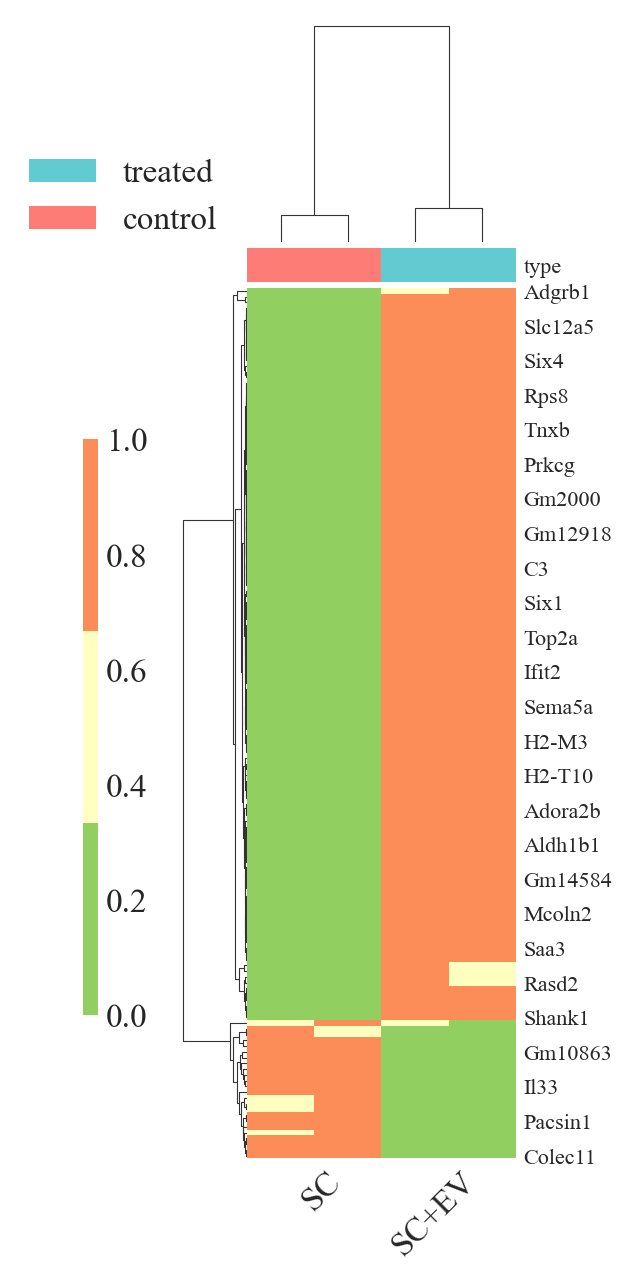

In [119]:
import palettable
meta=pd.read_csv('data/SC_meta.csv')
meta=meta.set_index(meta.columns[0])
col_c={
    'control':'#FD7C76',
    'treated':'#62CAD1'
}

a=sns.clustermap(SC_heatmap_data, 
               cmap=palettable.colorbrewer.diverging.RdYlGn_3_r.mpl_colors, 
               standard_scale = 0,figsize=(3,8),
              col_colors=meta['type'].map(col_c),
)
a.ax_heatmap.yaxis.set_tick_params(labelsize=10)
a.ax_heatmap.xaxis.set_tick_params(labelsize=15)
a.ax_heatmap.xaxis.set_ticklabels(['','SC','','SC+EV'])
labels=a.ax_heatmap.xaxis.get_ticklabels()
#a.ax_heatmap.xaxis.set_text(['','RAW','','','RAW+EV',''])
plt.setp(labels, rotation=45, horizontalalignment='right',)
for label in meta['type'].unique():
    a.ax_col_dendrogram.bar(0, 0, color=col_c[label],
                            label=label, linewidth=0)
a.ax_col_dendrogram.legend(loc="best", ncol=1,bbox_to_anchor=(-0.5, 0., 0.5, 0.5),fontsize=15)
a.cax.set_position([-.15, .2, .03, .45])
plt.setp(a.cax.yaxis.get_majorticklabels(), fontsize=15)
plt.savefig("result/SC_heatmap.png",dpi=300,bbox_inches = 'tight')
#plt.savefig("HVUEC_heatmap.png",dpi=300,bbox_inches = 'tight')

In [122]:
enr = gp.enrichr(gene_list=SC_heatmap_data.index.tolist(),
    gene_sets='KEGG_2019_Mouse',
    organism='Mouse', # don't forget to set organism to the one you desired! e.g. Yeast
    description='description',
    outdir='result/enrichment_KEGG_SC',
     # no_plot=True,
    cutoff=0.5 # test dataset, use lower value from range(0,1)
)
#subp=dotplot(enr.res2d, title=description,cmap='seismic')
#print(subp)
enr.res2d.head()

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,KEGG_2019_Mouse,Phagosome,8/180,0.000068,0.006684,0,0,6.400065,61.369208,C3;H2-T24;COLEC11;C1RA;H2-T22;H2-T10;H2-M3;H2-OB
1,KEGG_2019_Mouse,Allograft rejection,5/63,0.000113,0.006684,0,0,11.685758,106.159914,H2-T24;H2-T22;H2-T10;H2-M3;H2-OB
2,KEGG_2019_Mouse,Graft-versus-host disease,5/64,0.000122,0.006684,0,0,11.487114,103.490429,H2-T24;H2-T22;H2-T10;H2-M3;H2-OB
3,KEGG_2019_Mouse,Type I diabetes mellitus,5/69,0.000175,0.007169,0,0,10.587008,91.593898,H2-T24;H2-T22;H2-T10;H2-M3;H2-OB
4,KEGG_2019_Mouse,Autoimmune thyroid disease,5/78,0.000311,0.010203,0,0,9.277538,74.920621,H2-T24;H2-T22;H2-T10;H2-M3;H2-OB


In [123]:
kegg_result_sc=enr.res2d[enr.res2d['P-value']<0.05]
kegg_result_sc['logp']=-np.log(kegg_result_sc['Adjusted P-value'])
kegg_result_sc['logc']=np.log(kegg_result_sc['Combined Score'])
kegg_result_sc['num']=[int(i.split('/')[0]) for i in kegg_result_sc['Overlap']]

In [124]:
def plot_text_set(text):
  if len(text)>10:
    t=text.split(' ')
    n=0
    res=''
    for i in t:
      if n==0:
        res=i 
      else:
        res=res+'\n'+i
      n+=1
    return res
  else:
    return text

In [125]:
kegg_result_sc.to_excel('result/SC_KEGG_pathway(normal).xlsx')

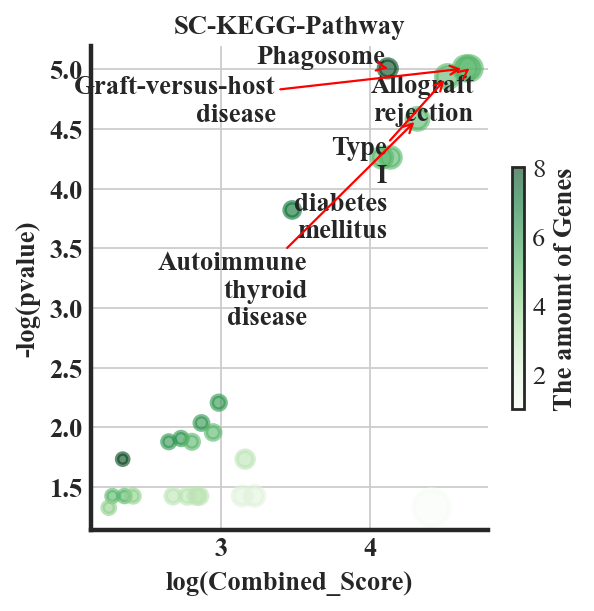

In [321]:
pp=plt.figure(figsize=(4,4))
#用ax控制图片
ax=pp.add_subplot(1,1,1)

plt.scatter(kegg_result_sc['logc'],kegg_result_sc['logp'],
      s=kegg_result_sc['Odds Ratio']*10,c=kegg_result_sc['num'],cmap='Greens',alpha=0.6,linewidth=2,)

test=kegg_result_sc['Term'].values
texts=[plt.text(kegg_result_sc[kegg_result_sc['Term']==i]['logc'].values[0], kegg_result_sc[kegg_result_sc['Term']==i]['logp'].values[0],
        plot_text_set(i)
        ,fontdict={'size':12,'weight':'bold'}) for i in test[:5]]

adjust_text(texts,only_move={'text': 'xy'},arrowprops=dict(arrowstyle='->', color='red'),)


#plt.annotate(me_result.index[0], xy=(me_result['Impact'][0],me_result['-log10(p)'][0]), xytext=(0.2,2),
#bbox=dict(boxstyle='round,pad=0.3', fc='white', alpha=0.5),arrowprops=dict(arrowstyle='-',color='black'),size=15)

#plt.annotate(me_result.index[1], xy=(me_result['Impact'][1],me_result['-log10(p)'][1]), xytext=(0.2,1.5),
#bbox=dict(boxstyle='round,pad=0.3', fc='white', alpha=0.5),arrowprops=dict(arrowstyle='-',color='black'),size=15)

#plt.annotate(me_result.index[2], xy=(me_result['Impact'][2],me_result['-log10(p)'][2]), xytext=(0.2,1),
#bbox=dict(boxstyle='round,pad=0.3', fc='white', alpha=0.5),arrowprops=dict(arrowstyle='-',color='black'),size=15)

#设置横纵坐标轴字体
plt.yticks(fontsize=12,fontweight='bold')
plt.xticks(fontsize=12,fontweight='bold')
#设置图注
#plt.legend(loc='center right', bbox_to_anchor=(0, -.5), ncol=3,fontsize=12)
#设置横纵标题
plt.ylabel('-log(pvalue)',fontsize=12,fontweight='bold')                   
plt.xlabel('log(Combined_Score)',fontsize=12,fontweight='bold')
plt.title('SC-KEGG-Pathway',fontsize=12,fontweight='bold')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_linewidth(2);###设置底部坐标轴的粗细
ax.spines['left'].set_linewidth(2);####设置左边坐标轴的粗细
ax.spines['right'].set_linewidth(2);###设置右边坐标轴的粗细
ax.spines['top'].set_linewidth(2);####设置上部坐标轴的粗细

cb=plt.colorbar(label="The amount of Genes",shrink=0.5) 
cb.ax.tick_params(labelsize=12)
#plt.xticks(fontsize=12)
plt.grid(None)
cb.set_label('The amount of Genes',fontdict={'size':12,'weight':'bold'})
#plt.savefig("kegg_ad.png",dpi=300,bbox_inches = 'tight')
plt.savefig("new_result/SC_kegg.png",dpi=300,bbox_inches = 'tight')

## gsea

In [126]:
gseada=data1.loc[data1['sig']!='normal']
gseada=data1
gseada['fcsign']=-np.sign(gseada['log2FoldChange'])
gseada['logp']=-np.log10(gseada['pvalue'])
gseada['metric']=gseada['logp']/gseada['fcsign']
gseada.head()

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,Symbol,Symbol_L,sig,log(padj),fcsign,logp,metric
Unnamed: 0,,,,,,,,,,,,,
ENSMUSG00000075145,0.000000,NaN,NaN,NaN,NaN,NaN,Olfr1155,OLFR1155,normal,NaN,NaN,NaN,NaN
ENSMUSG00000025815,25.034085,-0.142977,2.527035,-0.056579,0.954881,0.978500,Dhtkd1,DHTKD1,normal,0.009439,1.0,0.020051,0.020051
ENSMUSG00000106794,0.000000,NaN,NaN,NaN,NaN,NaN,Gm40293,GM40293,normal,NaN,NaN,NaN,NaN
ENSMUSG00000028911,499.367487,-0.435374,0.791461,-0.550089,0.582258,0.798255,Srsf4,SRSF4,normal,0.097859,1.0,0.234884,0.234884
ENSMUSG00000084071,4.129948,5.038713,2.955128,1.705074,0.088181,NaN,Gm13378,GM13378,normal,NaN,-1.0,1.054627,-1.054627


In [127]:
gseada=gseada.sort_values(by=['metric'],ascending=False)
gseada.head()

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,Symbol,Symbol_L,sig,log(padj),fcsign,logp,metric
Unnamed: 0,,,,,,,,,,,,,
ENSMUSG00000004113,125.606079,-3.175935,0.379161,-8.376213,5.465812e-17,4.902287e-13,Cacna1b,CACNA1B,down,12.309601,1.0,16.262345,16.262345
ENSMUSG00000089886,59.479871,-2.742158,0.429054,-6.391171,1.646200e-10,2.952953e-07,Gm16184,GM16184,down,6.529743,1.0,9.783517,9.783517
ENSMUSG00000075555,91.670087,-2.448581,0.413891,-5.916006,3.298541e-09,2.817583e-06,Gm10863,GM10863,down,5.550123,1.0,8.481678,8.481678
ENSMUSG00000036655,31.195048,-7.941015,1.368434,-5.802994,6.514102e-09,5.080433e-06,Colec11,COLEC11,down,5.294099,1.0,8.186145,8.186145
ENSMUSG00000061143,485.377763,-1.257900,0.218124,-5.766913,8.073650e-09,6.034381e-06,Maml3,MAML3,normal,5.219367,1.0,8.092930,8.092930


In [128]:
rnk=pd.DataFrame()
rnk['gene_name']=gseada.index
rnk['rnk']=gseada['metric'].values
k=1
total=0
for i in range(len(rnk)):
    if rnk.loc[i,'rnk']==np.inf: 
        total+=1

for i in range(len(rnk)):
    if rnk.loc[i,'rnk']==np.inf: 
        rnk.loc[i,'rnk']=307+(total-k)
        k+=1
    elif rnk.loc[i,'rnk']==-np.inf: 
        rnk.loc[i,'rnk']=-(300+k)
        k+=1
#rnk=rnk.replace(np.inf,300)
#rnk=rnk.replace(-np.inf,-300)
rnk['gene_name']=gseada['Symbol_L'].tolist()
rnk=rnk.dropna()
rnk.head()

,gene_name,rnk
0,CACNA1B,16.262345
1,GM16184,9.783517
2,GM10863,8.481678
3,COLEC11,8.186145
4,MAML3,8.092930


In [129]:
pre_res = gp.prerank(rnk=rnk, gene_sets='KEGG_2019_Mouse',
                     processes=16,
                     permutation_num=100, # reduce number to speed up testing
                     outdir='result/SC_gsea/prerank_report_kegg', format='png', seed=6)

2022-06-22 19:49:02,130 Input gene rankings contains duplicated IDs, Only use the duplicated ID with highest value!


In [130]:
pre_res.res2d.head()

,es,nes,pval,fdr,geneset_size,matched_size,genes,ledge_genes
Term,,,,,,,,
Complement and coagulation cascades,-0.665340,-1.995302,0.0,0.000000,88,60,PLG;SERPINE1;CFH;C6;SERPIND1;SERPING1;VTN;TFPI...,F8;SERPINF2;C5AR1;PLAU;VWF;ITGB2;CD59A;BDKRB2;...
DNA replication,-0.728915,-2.071171,0.0,0.000000,35,35,POLE4;RPA3;RNASEH2B;RNASEH1;RFC3;SSBP1;POLD4;P...,RFC1;RNASEH2C;POLD3;PRIM2;DNA2;PCNA;RFC5;POLD2...
Hematopoietic cell lineage,-0.637359,-1.993768,0.0,0.000000,94,75,KIT;CD44;ITGA5;ITGA6;CD1D1;IL7;ITGB3;CD19;IL11...,CD22;IL2RA;CSF2;CD36;CD14;H2-EB1;IL1A;H2-AA;IL...
Synaptic vesicle cycle,0.533167,2.056699,0.0,0.000000,77,66,CACNA1B;ATP6V1D;ATP6V0B;ATP6V0E;SLC6A9;ATP6V1F...,CACNA1B;ATP6V1D;ATP6V0B;ATP6V0E;SLC6A9;ATP6V1F...
Staphylococcus aureus infection,-0.728140,-1.980564,0.0,0.002063,95,44,KRT10;PLG;CFH;FPR1;MASP1;CAMP;HC;C1QB;H2-DMB1;...,MASP2;DEFA24;ICAM1;H2-AB1;FCGR1;H2-DMA;ITGAL;I...


In [131]:
# extract geneset terms in res2d
terms = pre_res.res2d.index
terms

Index(['Complement and coagulation cascades', 'DNA replication',
       'Hematopoietic cell lineage', 'Synaptic vesicle cycle',
       'Staphylococcus aureus infection',
       'C-type lectin receptor signaling pathway',
       'JAK-STAT signaling pathway', 'NF-kappa B signaling pathway',
       'Homologous recombination', 'Mismatch repair',
       ...
       'Phototransduction', 'RNA polymerase', 'Hippo signaling pathway',
       'Amino sugar and nucleotide sugar metabolism',
       'Fat digestion and absorption', 'Spliceosome',
       'Basal transcription factors', 'Mannose type O-glycan biosynthesis',
       'Ovarian steroidogenesis', 'Taste transduction'],
      dtype='object', name='Term', length=289)

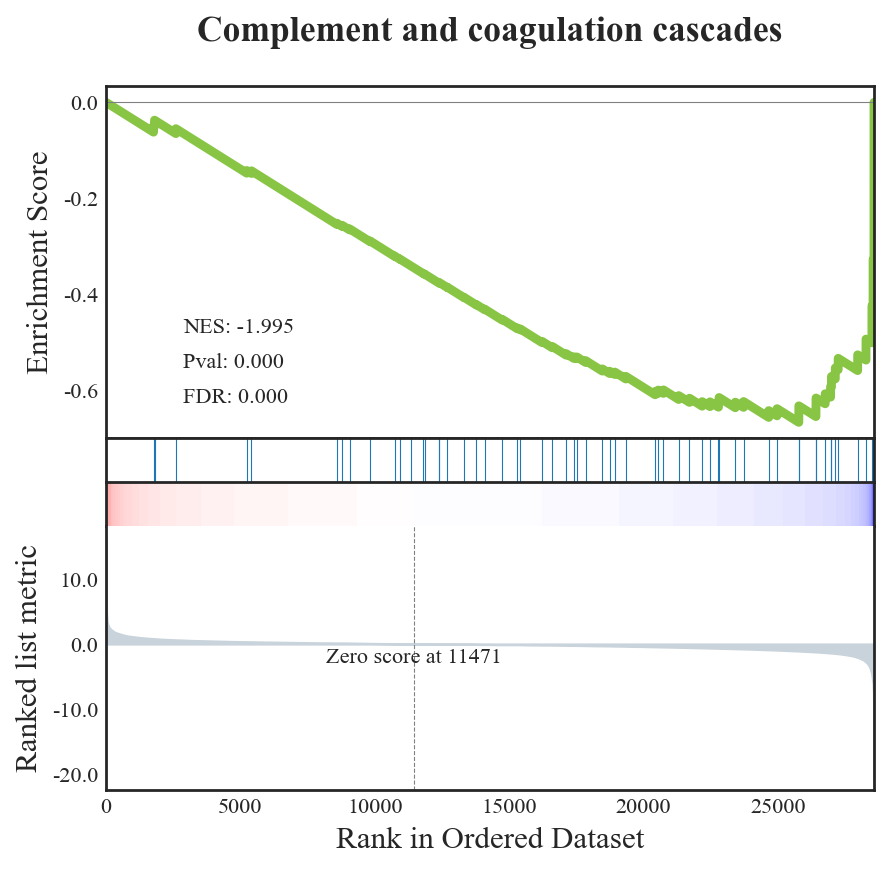

In [132]:
from gseapy.plot import gseaplot

# to save your figure, make sure that ofname is not None
gseaplot(rank_metric=pre_res.ranking, term=terms[0], **pre_res.results[terms[0]])

# Mouse

In [133]:
tf_mouse=pd.read_csv('data/tf_names_mouse.csv')
tf_mouse['TF_L']=[i.upper() for i in tf_mouse['TF']]
tf_mouse.head()

,Unnamed: 0,TF,TF_L
0,0,Hoxa9,HOXA9
1,1,Zfp128,ZFP128
2,2,Zfp853,ZFP853
3,3,Nr1h2,NR1H2
4,4,Nr1h3,NR1H3


In [134]:
raw_gsea=pd.read_csv(r'result/RAW_gsea/prerank_report_kegg/gseapy.prerank.gene_sets.report.csv')
raw_gsea=raw_gsea.loc[(raw_gsea['pval']<0.01) & (raw_gsea['fdr']<0.01)]
raw_gsea['logp']=-np.log10(raw_gsea['pval']+0.001)
raw_gsea['com']=raw_gsea['matched_size']/raw_gsea['geneset_size']
#sc_data.set_index(sc_data.columns[0],inplace=True)
raw_gsea.head()

,Term,es,nes,pval,fdr,geneset_size,matched_size,genes,ledge_genes,logp,com
0,Complement and coagulation cascades,0.880971,1.673290,0.0,0.0,88,65,SERPINE1;ITGAM;C3AR1;PLAU;C5AR1;CLU;C3;BDKRB2;...,SERPINE1;ITGAM;C3AR1;PLAU;C5AR1;CLU;C3;BDKRB2;...,3.0,0.738636
1,Cytokine-cytokine receptor interaction,0.835920,1.718526,0.0,0.0,292,204,IL1RN;IL10RA;TNFRSF9;CXCL2;LIF;CCL4;IL13RA1;IL...,IL1RN;IL10RA;TNFRSF9;CXCL2;LIF;CCL4;IL13RA1;IL...,3.0,0.698630
2,HIF-1 signaling pathway,0.855529,1.685912,0.0,0.0,104,99,VEGFA;PFKFB3;SERPINE1;ENO2;SLC2A1;EGLN1;HK1;PD...,VEGFA;PFKFB3;SERPINE1;ENO2;SLC2A1;EGLN1;HK1;PD...,3.0,0.951923
3,Neuroactive ligand-receptor interaction,0.826257,1.717454,0.0,0.0,348,192,GIPR;THRA;ADM;C3AR1;C5AR1;C3;BDKRB2;GPR35;TSPO...,GIPR;THRA;ADM;C3AR1;C5AR1;C3;BDKRB2;GPR35;TSPO...,3.0,0.551724
4,RNA transport,-0.782943,-1.987347,0.0,0.0,167,155,EIF4EBP1;CYFIP1;CYFIP2;EIF1B;ELAC1;SNUPN;EIF2S...,ALYREF2;RPP40;EIF3F;TGS1;EIF2S3X;NUP50;EIF2B3;...,3.0,0.928144


In [135]:
raw_exp=pd.read_csv('data/RAW_counts.csv')
raw_exp=raw_exp.set_index(raw_exp.columns[0])
ret_index=list(set(pair_mouse.index.tolist()) & set(raw_exp.index.tolist()))
raw_exp=raw_exp.loc[ret_index]
raw_exp['Symbol']=pair_mouse.loc[ret_index]['symbol']
raw_exp['Symbol_L']=pair_mouse.loc[ret_index]['symbol_L']
raw_exp.head()

,RAW1,RAW1yuan,RAW2,RAW2yuan,RAW3,RAW3yuan,Symbol,Symbol_L
Geneid,,,,,,,,
ENSMUSG00000075145,0,0,0,0,0,0,Olfr1155,OLFR1155
ENSMUSG00000025815,0,0,0,0,0,0,Dhtkd1,DHTKD1
ENSMUSG00000106794,0,0,0,0,0,0,Gm40293,GM40293
ENSMUSG00000028911,456,599,434,553,452,631,Srsf4,SRSF4
ENSMUSG00000084071,15,12,13,21,24,19,Gm13378,GM13378


In [136]:
raw_result=pd.DataFrame(columns=['Term','TF','TF_mean'])
for i in range(len(raw_gsea)):
    a1=raw_gsea.iloc[i]['ledge_genes'].split(';')
    a2=tf_mouse['TF_L']
    ret_a=list(set(a1) & set(a2))
    if len(ret_a)!=0:
        ret_exp=[]
        for j in ret_a:
            exp=(raw_exp.loc[raw_exp['Symbol_L']==j,['RAW1yuan','RAW2yuan','RAW3yuan']].mean(axis=1)+0.0001)/ \
                (raw_exp.loc[raw_exp['Symbol_L']==j,['RAW1','RAW3','RAW2']].mean(axis=1)+0.0001)
            ret_exp.append(exp.values[0])
        raw_result=raw_result.append({'Term':raw_gsea.iloc[i]['Term'],'TF':ret_a,'TF_mean':np.log2(np.mean(ret_exp))},ignore_index=True)
        
raw_result.set_index(raw_result.columns[0],inplace=True)

In [137]:
raw_result.replace(np.inf,1).to_excel('result/RAW_TF_Pathway(GSEA).xlsx')
raw_result.replace(np.inf,1)

,TF,TF_mean
Term,,
HIF-1 signaling pathway,"[HIF1A, EDN1, STAT3]",-1.494967
Neuroactive ligand-receptor interaction,"[EDN1, NR3C1, THRA]",-1.663466
RNA transport,"[NUP133, NCBP2, RAN, MAGOH, DDX20, NUP107]",0.523234
Ribosome,"[RPS4X, RPS10, RPL6, MRPL2, MRPL1, RPL35]",0.243371
Ribosome biogenesis in eukaryotes,"[GAR1, RAN, UTP18, AK6]",0.657859
Spliceosome,"[PQBP1, HNRNPC, LSM6, CDC5L, NCBP2, SNRNP70, M...",0.439235
mRNA surveillance pathway,"[CPSF4, PPP2R3D, NCBP2, MAGOH, DAZAP1, CSTF2]",0.349394
JAK-STAT signaling pathway,"[STAT3, STAT6, STAT2, STAT5A]",-0.904823
Fanconi anemia pathway,"[FAAP24, BRCA1]",0.653348


In [138]:
sc_gsea=pd.read_csv(r'result/SC_gsea/prerank_report_kegg/gseapy.prerank.gene_sets.report.csv')
sc_gsea=sc_gsea.loc[(sc_gsea['pval']<0.01) & (sc_gsea['fdr']<0.005)]
sc_gsea['logp']=-np.log10(sc_gsea['pval']+0.001)
sc_gsea['com']=sc_gsea['matched_size']/sc_gsea['geneset_size']
#sc_data.set_index(sc_data.columns[0],inplace=True)
sc_gsea

,Term,es,nes,pval,fdr,geneset_size,matched_size,genes,ledge_genes,logp,com
0,Complement and coagulation cascades,-0.665340,-1.995302,0.0,0.000000,88,60,PLG;SERPINE1;CFH;C6;SERPIND1;SERPING1;VTN;TFPI...,F8;SERPINF2;C5AR1;PLAU;VWF;ITGB2;CD59A;BDKRB2;...,3.0,0.681818
1,DNA replication,-0.728915,-2.071171,0.0,0.000000,35,35,POLE4;RPA3;RNASEH2B;RNASEH1;RFC3;SSBP1;POLD4;P...,RFC1;RNASEH2C;POLD3;PRIM2;DNA2;PCNA;RFC5;POLD2...,3.0,1.000000
2,Hematopoietic cell lineage,-0.637359,-1.993768,0.0,0.000000,94,75,KIT;CD44;ITGA5;ITGA6;CD1D1;IL7;ITGB3;CD19;IL11...,CD22;IL2RA;CSF2;CD36;CD14;H2-EB1;IL1A;H2-AA;IL...,3.0,0.797872
3,Synaptic vesicle cycle,0.533167,2.056699,0.0,0.000000,77,66,CACNA1B;ATP6V1D;ATP6V0B;ATP6V0E;SLC6A9;ATP6V1F...,CACNA1B;ATP6V1D;ATP6V0B;ATP6V0E;SLC6A9;ATP6V1F...,3.0,0.857143
4,Staphylococcus aureus infection,-0.728140,-1.980564,0.0,0.002063,95,44,KRT10;PLG;CFH;FPR1;MASP1;CAMP;HC;C1QB;H2-DMB1;...,MASP2;DEFA24;ICAM1;H2-AB1;FCGR1;H2-DMA;ITGAL;I...,3.0,0.463158
5,C-type lectin receptor signaling pathway,-0.638511,-1.983865,0.0,0.002579,112,96,MAPK12;PPP3CC;MAPK3;CBLB;RELB;PIK3R1;MAPK8;RAF...,CALML4;IRF1;ITPR2;PLCG2;CARD9;TNF;NLRP3;PRKCD;...,3.0,0.857143
6,JAK-STAT signaling pathway,-0.606517,-1.948086,0.0,0.002579,164,127,IL2RB;PDGFB;IFNLR1;OSMR;LEPR;CNTF;LIF;STAT6;IL...,SOCS1;SOS1;IL12RB1;IL6RA;IL4;CSF2RA;PTPN6;MCL1...,3.0,0.774390
7,NF-kappa B signaling pathway,-0.614233,-1.951658,0.0,0.002948,102,88,GADD45B;VCAM1;RELB;PLCG1;LTBR;CSNK2B;PIAS4;NFK...,IRAK4;MAP3K14;BCL2A1A;TICAM1;MAP3K7;LTB;MYD88;...,3.0,0.862745
8,Homologous recombination,-0.698436,-1.973376,0.0,0.003439,41,40,MUS81;RBBP8;RPA3;BABAM2;TOP3A;SSBP1;SEM1;POLD4...,SYCP3;BABAM1;XRCC2;POLD3;ABRAXAS1;POLD2;RPA1;R...,3.0,0.975610
10,Kaposi sarcoma-associated herpesvirus infection,-0.576915,-1.917153,0.0,0.004127,216,186,CDK4;MAP2K1;IRF3;PREX1;PDGFB;CXCL3;GNG10;MAPK1...,MAPKAPK2;IKBKE;CASP3;TYK2;TNFRSF1A;PIK3CG;HIF1...,3.0,0.861111


In [139]:
sc_exp=pd.read_csv('data/SC_counts.csv')
sc_exp=sc_exp.set_index(sc_exp.columns[0])
ret_index=list(set(pair_mouse.index.tolist()) & set(sc_exp.index.tolist()))
sc_exp=sc_exp.loc[ret_index]
sc_exp['Symbol']=pair_mouse.loc[ret_index]['symbol']
sc_exp['Symbol_L']=pair_mouse.loc[ret_index]['symbol_L']
sc_exp.head()

,SC2,SC2yuan,SC3,SC3yuan,Symbol,Symbol_L
Geneid,,,,,,
ENSMUSG00000075145,0,0,0,0,Olfr1155,OLFR1155
ENSMUSG00000025815,0,17,2,29,Dhtkd1,DHTKD1
ENSMUSG00000106794,0,0,0,0,Gm40293,GM40293
ENSMUSG00000028911,515,447,508,573,Srsf4,SRSF4
ENSMUSG00000084071,21,0,19,0,Gm13378,GM13378


In [140]:
sc_result=pd.DataFrame(columns=['Term','TF','TF_mean'])
for i in range(len(sc_gsea)):
    a1=sc_gsea.iloc[i]['ledge_genes'].split(';')
    a2=tf_mouse['TF_L']
    ret_a=list(set(a1) & set(a2))
    if len(ret_a)!=0:
        ret_exp=[]
        for j in ret_a:
            exp=(sc_exp.loc[sc_exp['Symbol_L']==j,['SC2','SC3']].mean(axis=1)+0.0001)/ \
                (sc_exp.loc[sc_exp['Symbol_L']==j,['SC2yuan','SC3yuan']].mean(axis=1)+0.0001)
            ret_exp.append(exp.values[0])
        sc_result=sc_result.append({'Term':sc_gsea.iloc[i]['Term'],'TF':ret_a,'TF_mean':np.log2(np.mean(ret_exp))},ignore_index=True)
        
sc_result.set_index(sc_result.columns[0],inplace=True)

In [141]:
sc_result.replace(np.inf,1).to_excel('result/SC_TF_Pathway(GSEA).xlsx')
sc_result.replace(np.inf,1)

,TF,TF_mean
Term,,
Complement and coagulation cascades,[CD59A],5.6667
DNA replication,"[RFC2, RNASEH2C, POLD2]",3.191279
Hematopoietic cell lineage,[CD59A],5.6667
C-type lectin receptor signaling pathway,"[IRF9, BCL3, NFATC1, IRF1, MDM2, NFATC2, STAT1]",3.63087
JAK-STAT signaling pathway,"[IRF9, SOCS4, STAT1]",3.320073
NF-kappa B signaling pathway,[PARP1],3.142243
Homologous recombination,"[BRCA1, POLD2]",3.481525
Kaposi sarcoma-associated herpesvirus infection,"[IRF9, E2F1, NFATC1, NFATC2, E2F2, HIF1A, IRF7...",4.747791
Small cell lung cancer,"[E2F1, E2F2]",4.415459


In [142]:
plot_raw=raw_gsea.loc[raw_gsea['Term'].isin(raw_result.index)]
plot_raw['TF']=raw_result.loc[plot_raw['Term']]['TF'].values
plot_raw['TF_mean']=raw_result.loc[plot_raw['Term']]['TF_mean'].values
plot_raw.head()

,Term,es,nes,pval,fdr,geneset_size,matched_size,genes,ledge_genes,logp,com,TF,TF_mean
2,HIF-1 signaling pathway,0.855529,1.685912,0.0,0.0,104,99,VEGFA;PFKFB3;SERPINE1;ENO2;SLC2A1;EGLN1;HK1;PD...,VEGFA;PFKFB3;SERPINE1;ENO2;SLC2A1;EGLN1;HK1;PD...,3.0,0.951923,"[HIF1A, EDN1, STAT3]",-1.494967
3,Neuroactive ligand-receptor interaction,0.826257,1.717454,0.0,0.0,348,192,GIPR;THRA;ADM;C3AR1;C5AR1;C3;BDKRB2;GPR35;TSPO...,GIPR;THRA;ADM;C3AR1;C5AR1;C3;BDKRB2;GPR35;TSPO...,3.0,0.551724,"[EDN1, NR3C1, THRA]",-1.663466
4,RNA transport,-0.782943,-1.987347,0.0,0.0,167,155,EIF4EBP1;CYFIP1;CYFIP2;EIF1B;ELAC1;SNUPN;EIF2S...,ALYREF2;RPP40;EIF3F;TGS1;EIF2S3X;NUP50;EIF2B3;...,3.0,0.928144,"[NUP133, NCBP2, RAN, MAGOH, DDX20, NUP107]",0.523234
5,Ribosome,-0.781531,-1.922808,0.0,0.0,170,132,RPL18A;MRPL14;RPL34-PS1;RPS27RT;RPL13A;RPL22;R...,RPS2;MRPL22;RPS15;MRPS10;RPL18;RPS8;RPL32;RPS4...,3.0,0.776471,"[RPS4X, RPS10, RPL6, MRPL2, MRPL1, RPL35]",0.243371
6,Ribosome biogenesis in eukaryotes,-0.895325,-1.930156,0.0,0.0,115,76,NXF7;EFL1;XRN1;REXO5;CSNK2A1;NXF3;NXF1;RPP25;P...,RPP30;GNL2;GNL3L;CSNK2A2;SPATA5;POP7;POP5;XRN2...,3.0,0.660870,"[GAR1, RAN, UTP18, AK6]",0.657859


In [143]:
plot_sc=sc_gsea.loc[sc_gsea['Term'].isin(sc_result.index)]
plot_sc['TF']=sc_result.loc[plot_sc['Term']]['TF'].values
plot_sc['TF_mean']=sc_result.loc[plot_sc['Term']]['TF_mean'].values
plot_sc.head()

,Term,es,nes,pval,fdr,geneset_size,matched_size,genes,ledge_genes,logp,com,TF,TF_mean
0,Complement and coagulation cascades,-0.665340,-1.995302,0.0,0.000000,88,60,PLG;SERPINE1;CFH;C6;SERPIND1;SERPING1;VTN;TFPI...,F8;SERPINF2;C5AR1;PLAU;VWF;ITGB2;CD59A;BDKRB2;...,3.0,0.681818,[CD59A],5.6667
1,DNA replication,-0.728915,-2.071171,0.0,0.000000,35,35,POLE4;RPA3;RNASEH2B;RNASEH1;RFC3;SSBP1;POLD4;P...,RFC1;RNASEH2C;POLD3;PRIM2;DNA2;PCNA;RFC5;POLD2...,3.0,1.000000,"[RFC2, RNASEH2C, POLD2]",3.191279
2,Hematopoietic cell lineage,-0.637359,-1.993768,0.0,0.000000,94,75,KIT;CD44;ITGA5;ITGA6;CD1D1;IL7;ITGB3;CD19;IL11...,CD22;IL2RA;CSF2;CD36;CD14;H2-EB1;IL1A;H2-AA;IL...,3.0,0.797872,[CD59A],5.6667
5,C-type lectin receptor signaling pathway,-0.638511,-1.983865,0.0,0.002579,112,96,MAPK12;PPP3CC;MAPK3;CBLB;RELB;PIK3R1;MAPK8;RAF...,CALML4;IRF1;ITPR2;PLCG2;CARD9;TNF;NLRP3;PRKCD;...,3.0,0.857143,"[IRF9, BCL3, NFATC1, IRF1, MDM2, NFATC2, STAT1]",3.63087
6,JAK-STAT signaling pathway,-0.606517,-1.948086,0.0,0.002579,164,127,IL2RB;PDGFB;IFNLR1;OSMR;LEPR;CNTF;LIF;STAT6;IL...,SOCS1;SOS1;IL12RB1;IL6RA;IL4;CSF2RA;PTPN6;MCL1...,3.0,0.774390,"[IRF9, SOCS4, STAT1]",3.320073


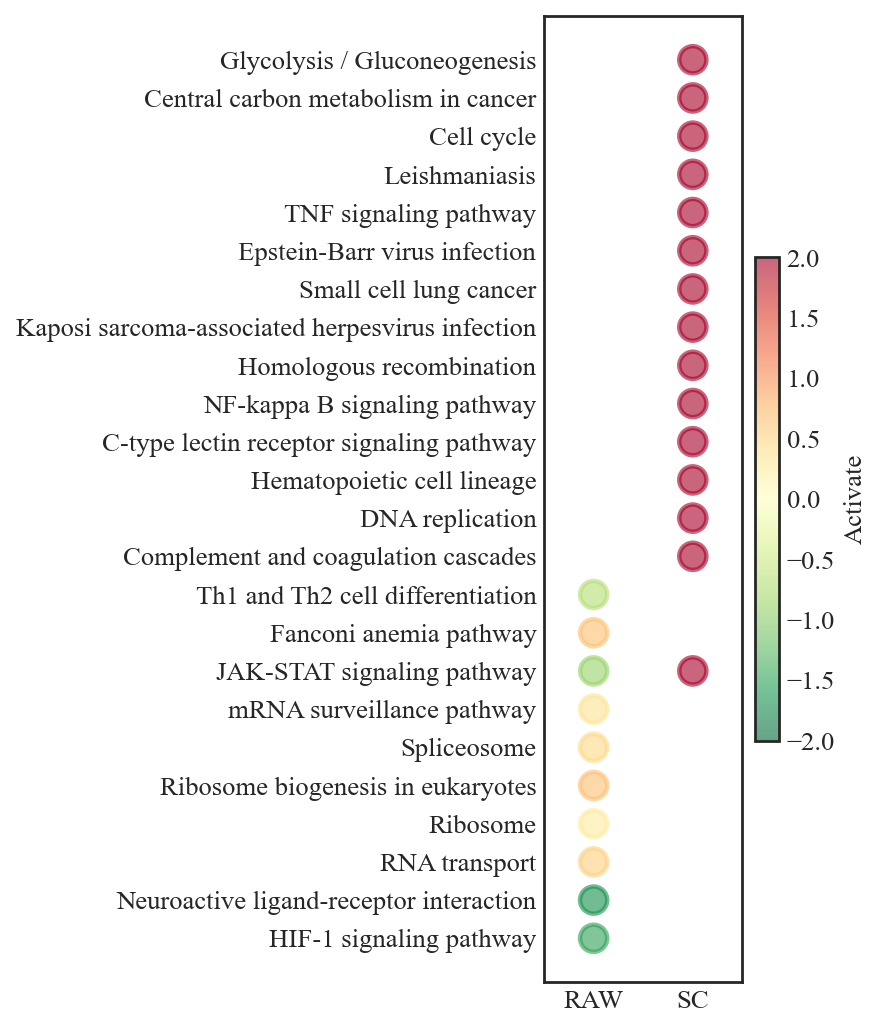

In [144]:
import matplotlib.pyplot as plt
import palettable
pp=plt.figure(figsize=(2,8))
a=pp.add_subplot(1,1,1)
a=plt.scatter(np.zeros(len(plot_raw)),plot_raw['Term'],s=plot_raw['logp']*50,alpha=0.6,linewidth=2,
            c=plot_raw['TF_mean'],vmin=-2,vmax=2,
            cmap='RdYlGn_r')
plt.scatter(np.zeros(len(plot_sc))+1,plot_sc['Term'],s=plot_sc['logp']*50,alpha=0.6,linewidth=2,
            c=plot_sc['TF_mean'],vmin=-2,vmax=2,
            cmap='RdYlGn_r')
plt.xticks([0,1],['RAW','SC'])
plt.xticks(range(-1,3,1))
#plt.colorbar(a)
cb=plt.colorbar(a,shrink=0.5,label='Activate')
#cb=plt.colorbar(label="The amount of Genes",shrink=0.5) 
cb.ax.tick_params(labelsize=12)
#plt.xticks(fontsize=12)
cb.set_label('Activate',fontdict={'size':12,'weight':'normal'})
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.xlim(-0.5,1.5)
plt.savefig('result/mouse_pathway.png',dpi=300,bbox_inches = 'tight')